In [1]:
from datetime import datetime, timedelta, time
import pandas as pd
import numpy as np
import datajoint as dj
from pipeline import pipeline_tools, lab, experiment, behavioranal
dj.conn()
import matplotlib.pyplot as plt
import decimal
from scipy.stats import norm
import scipy
%matplotlib inline
from plot.plot_behavior import *

IndentationError: unexpected indent (lab.py, line 1)

# Weight change and water consumption
All mice returned to baseline weight despite they drink little water..

D:\Han_Sync\Svoboda\Scripts\DataPipeline\plot\plot_behavior.py:102: RuntimeWarning: invalid value encountered in long_scalars
  early_lick_rate = (df_earlylick == 'early').values.sum()/trialnum


KeyboardInterrupt: 

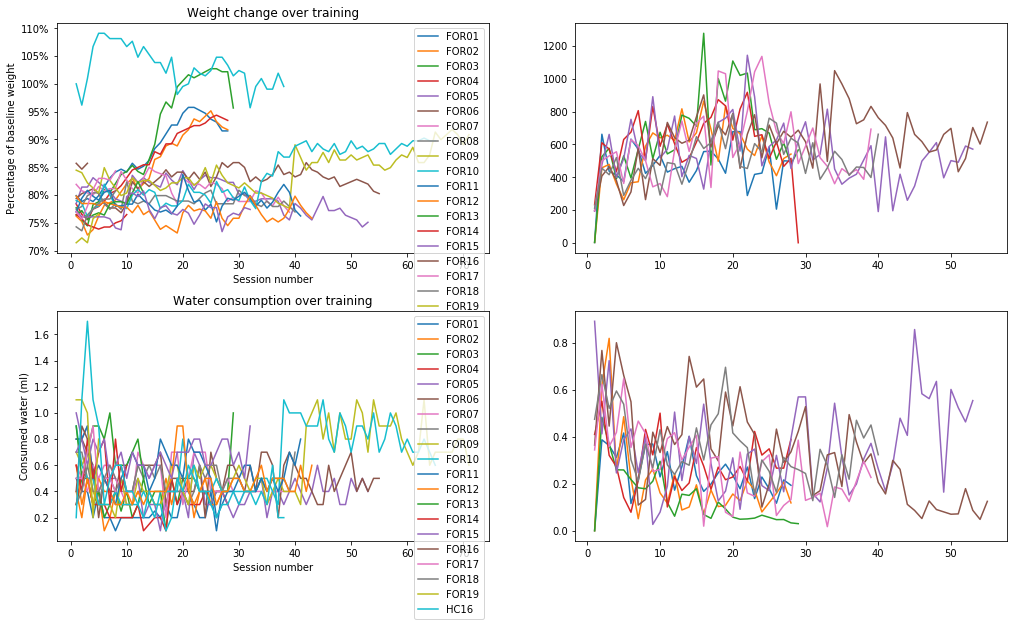

In [2]:
plot_weight_water_early_lick()

In [2]:
axess = list()
colnum = 4
fig=plt.figure()
df_surgery = pd.read_csv(dj.config['locations.metadata_behavior']+'Surgery.csv')
col = 0
row = 0
for ididx,ID in enumerate(df_surgery['ID']):
    try:
        df_now = pd.read_csv(dj.config['locations.metadata_behavior']+ID+'.csv')
        try:
            endidx = np.where(np.isnan(df_now['Weight']))[0][0]
        except:
            endidx = len(df_now)
        weightdiff = np.diff(df_now['Weight'][:endidx])
        prevwater = df_now['Extra water'][:endidx-1] + df_now['Water during training'][:endidx-1]
        needed = df_now['Training type'][:endidx-1] != 'restriction'
        prevwater = prevwater[needed]
        weightdiff = weightdiff[needed]
        p = np.polyfit(prevwater,weightdiff,1)
        if col >= colnum:
            col = 0
            row -= 1
        col +=1
        axess.append(fig.add_axes([col,row,.8,.8]))#axess.append(fig.add_axes([0,-ididx,1,.8]))
        axess[-1].plot(prevwater,weightdiff,'ko')
        axess[-1].plot([0,1],np.polyval(p,[0,1]),'k-')
        axess[-1].set_title(ID + ' has stationary weight at {0:.2f} ml water'.format(p[1]/p[0]*-1))
        axess[-1].set_xlabel('water consumed (ml)')
        axess[-1].set_ylabel('weight gained (g)')
        
    except:
        pass
        #print(ID+ ' has no water restriction table')

FileNotFoundError: [Errno 2] File b'/home/rozmar/Data/Behavior/Metadata/Surgery.csv' does not exist: b'/home/rozmar/Data/Behavior/Metadata/Surgery.csv'

<Figure size 432x288 with 0 Axes>

# Autowater
Autowater (water cue after multiple miss trials) was not used from week 2, except for FOR01 who had a huge bias on a few days
(autowater was turned on if the animal igored 10 trials in a row at the end of the session, these are the small bumps from the second week)

Text(0.5, 1.0, 'Autowater')

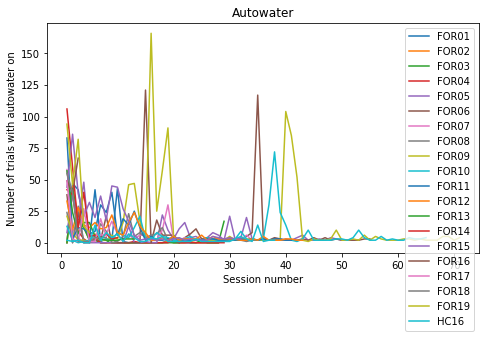

In [4]:
df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * experiment.SessionDetails)
subject_names = df_subject_wr['water_restriction_number'].unique()
subject_names.sort()
fig=plt.figure()
ax_autowater=fig.add_axes([0,0,1,.8])
for i,wr_name in enumerate(subject_names):
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    key = {'subject_id':subject_id}
    sessionnum = len(experiment.Session()&key)
    autowater_nums = list()
    
    for session in range(1,sessionnum+1):  
        key = {'session':session,'subject_id':subject_id}    
        autowater_num = len((experiment.TrialNote()&key))
        autowater_nums.append(autowater_num)
    ax_autowater.plot(range(1,len(autowater_nums)+1),autowater_nums)   #,linewidth=len(subject_names)+.5-i 
ax_autowater.legend(subject_names)
ax_autowater.set_xlabel('Session number')
ax_autowater.set_ylabel('Number of trials with autowater on')
ax_autowater.set_title('Autowater')   

# reaction times for the last session:
The first two mice (Bari-Cohen training) are trying to guess the GO cue

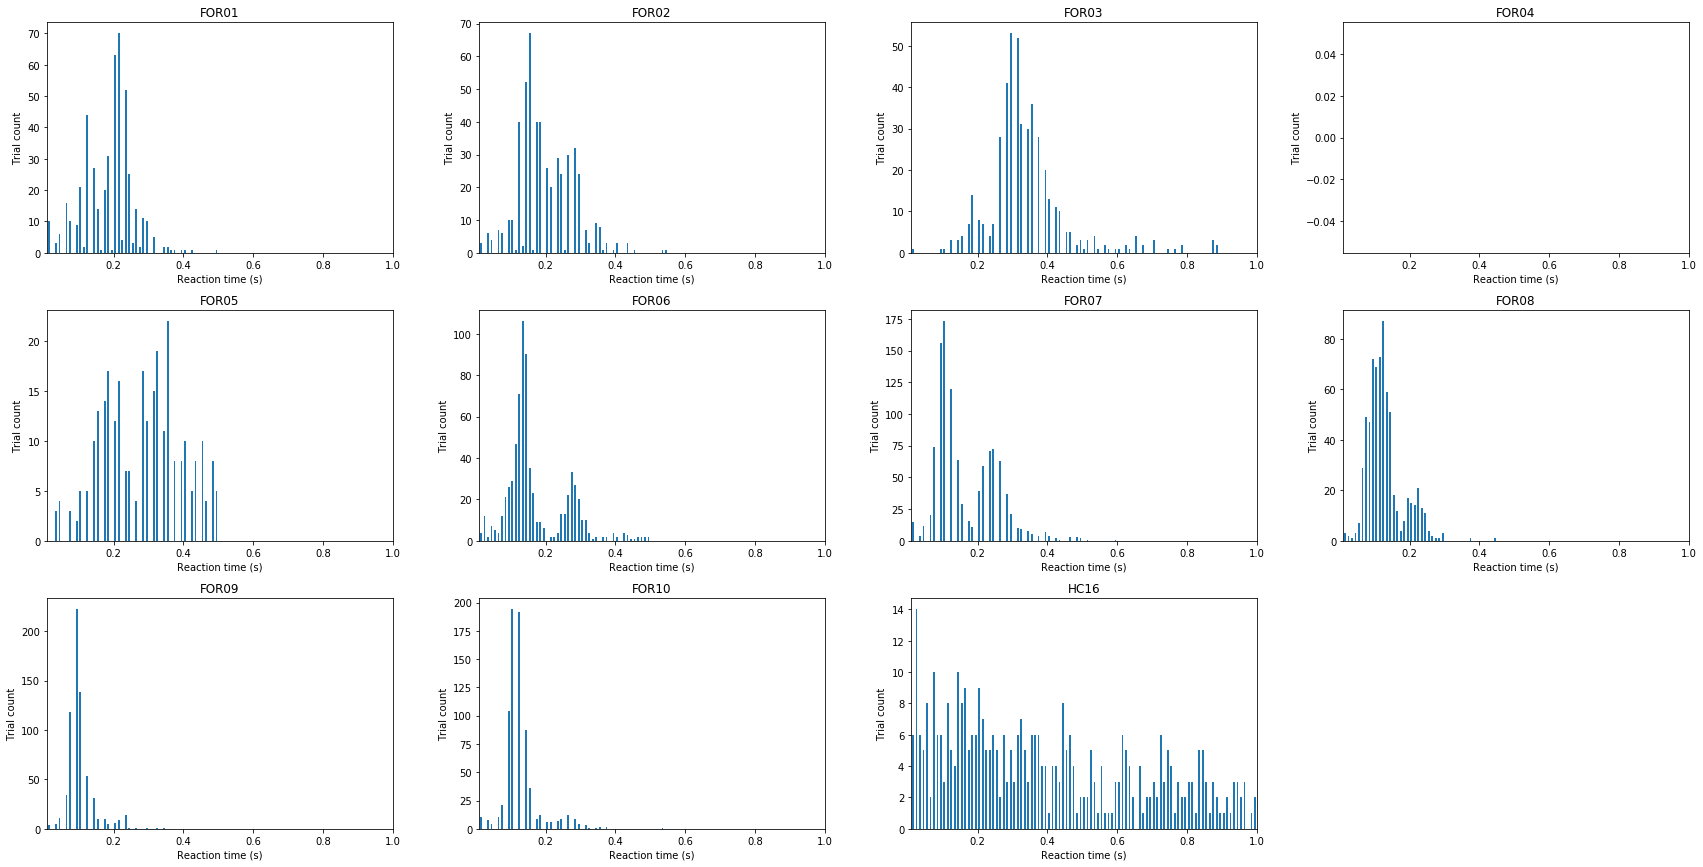

In [5]:
df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * experiment.SessionDetails)
subject_names = df_subject_wr['water_restriction_number'].unique()
subject_names.sort()

fig=plt.figure()
ax_RT = list()
colnum = 4
col = 0
row = 0
for i,subject in enumerate(subject_names):
    key = dict()
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+subject+'"').fetch('subject_id')[0]
    key['subject_id'] = subject_id
    session = (experiment.Session()&key).fetch('session').max()
    key['session'] = session
    df_reactiontime = pd.DataFrame((behavioranal.SessionReactionTimeHistogram() & key)*(lab.WaterRestriction &key))
    while len(df_reactiontime)<1:
        session -= 1
        key['session'] = session
        df_reactiontime = pd.DataFrame((behavioranal.SessionReactionTimeHistogram() & key)*(lab.WaterRestriction &key))
        
    if col >= colnum:
        col = 0
        row -= 1
    col +=1
    #ax_RT.append(fig.add_axes([np.floor((i/4)%4),-1*(i%4),.8,.8]))
    ax_RT.append(fig.add_axes([col,row,.8,.8]))
    idx = df_reactiontime['water_restriction_number'] == subject
    bins = df_reactiontime['reaction_time_bins'][idx].values[0][1:]
    edges = [np.min(bins),np.max(bins)]
    bins = bins - (bins[1] -bins[0])/2
    vals = df_reactiontime['reaction_time_values_all_trials'][idx].values.tolist()[0]
    ax_RT[-1].bar(bins,vals, (bins[1] -bins[0])/2)
    ax_RT[-1].set_xlim(edges)
    ax_RT[-1].set_title(subject)
    ax_RT[-1].set_xlabel('Reaction time (s)')
    ax_RT[-1].set_ylabel('Trial count')

# Number of licks on miss trials after the first lick in each session:
(if the retraction is fast enough, it should be 0)  
Sessions 1-7 : softcode and slow motor movement  
Sessions 7-11 : softcode and fast motor movement  
Sessions 12-19: same as above but two bpods controlled from the same PC  
Sessions 19- : zaber motor is directly triggered  

Text(0.5, 1.0, 'Lick count on miss trials')

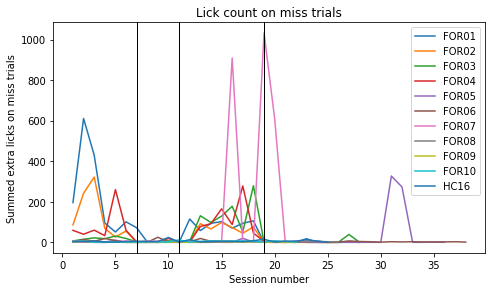

In [6]:
#%% licks on miss trials

df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * experiment.SessionDetails)
subject_names = df_subject_wr['water_restriction_number'].unique()
subject_names.sort()


df_misslicknums = pd.DataFrame()
fig=plt.figure()
ax_misslick = fig.add_axes([0,0,1,.8])
for wr_name in subject_names:
    #%
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    key = {'subject_id':subject_id}   
    df_lickrhythm = pd.DataFrame((behavioranal.SessionLickRhythmHistogram() & key)*(lab.WaterRestriction &key))
    #%
    
    sessionnum = list()
    licknum = list()
    if len(df_lickrhythm)>0:
        for i,session in enumerate(df_lickrhythm['session']):
            idx = df_lickrhythm['session'] == session
            bins = df_lickrhythm['lick_rhythm_bins'][idx].values[0][1:]
            edges = [np.min(bins),np.max(bins)]
            bins = bins - (bins[1] -bins[0])/2 
            vals = df_lickrhythm['lick_rhythm_values_miss_trials'][idx].values.tolist()[0]
            sessionnum.append(session)
            licknum.append(vals[bins>.015].sum())       
        ax_misslick.plot(sessionnum,licknum)
protocolchanges = [7,11,19]
ylimedges = ax_misslick.get_ylim()
ax_misslick.plot(protocolchanges,np.ones(len(protocolchanges))*np.mean(ylimedges),'k|',markersize = np.diff(ylimedges))
ax_misslick.set_ylabel('Summed extra licks on miss trials')
ax_misslick.set_xlabel('Session number')
ax_misslick.legend(subject_names)
ax_misslick.set_title('Lick count on miss trials')


/home/rozmar/Scripts/Python/DataPipeline/plot/plot_behavior.py:744: RuntimeWarning: invalid value encountered in log2
  xvals = np.log2(xvals)
/home/rozmar/Scripts/Python/DataPipeline/plot/plot_behavior.py:744: RuntimeWarning: invalid value encountered in log2
  xvals = np.log2(xvals)
/home/rozmar/Scripts/Python/DataPipeline/plot/plot_behavior.py:744: RuntimeWarning: invalid value encountered in log2
  xvals = np.log2(xvals)
/home/rozmar/Scripts/Python/DataPipeline/plot/plot_behavior.py:744: RuntimeWarning: invalid value encountered in log2
  xvals = np.log2(xvals)
/home/rozmar/Scripts/Python/DataPipeline/plot/plot_behavior.py:744: RuntimeWarning: invalid value encountered in log2
  xvals = np.log2(xvals)
/home/rozmar/Scripts/Python/DataPipeline/plot/plot_behavior.py:744: RuntimeWarning: invalid value encountered in log2
  xvals = np.log2(xvals)
/home/rozmar/Scripts/Python/DataPipeline/plot/plot_behavior.py:744: RuntimeWarning: invalid value encountered in log2
  xvals = np.log2(xvals)

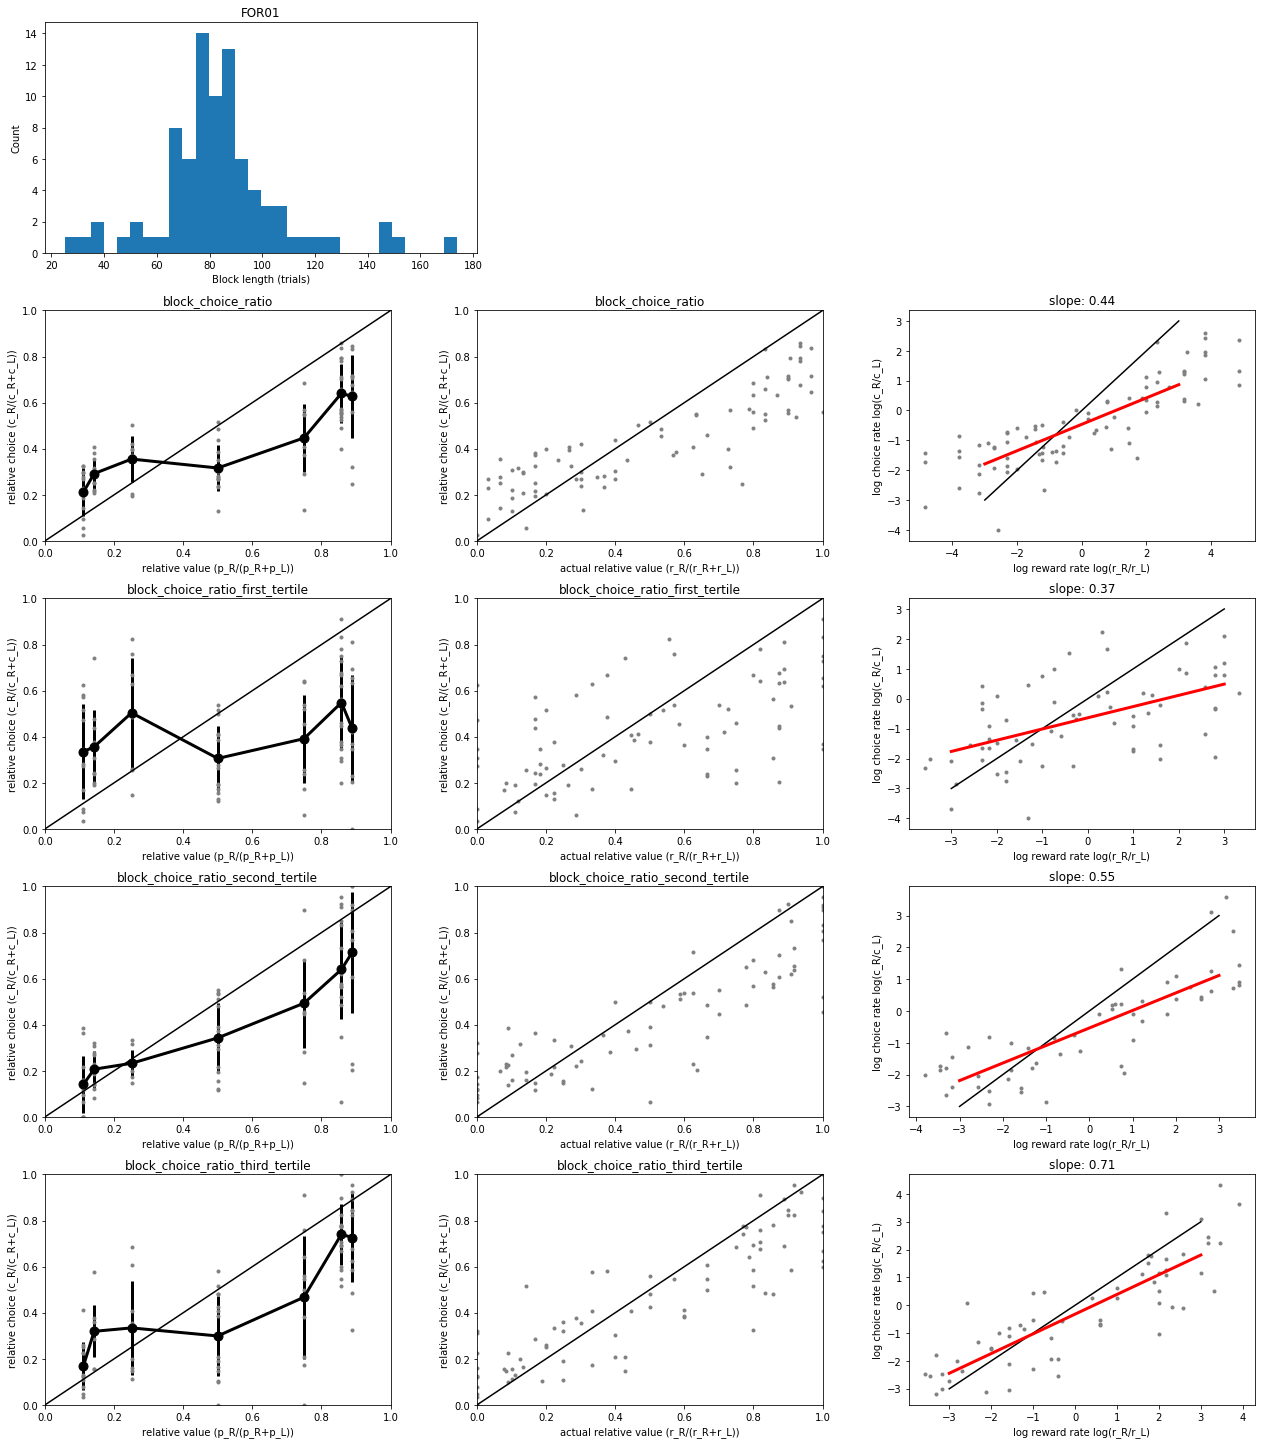

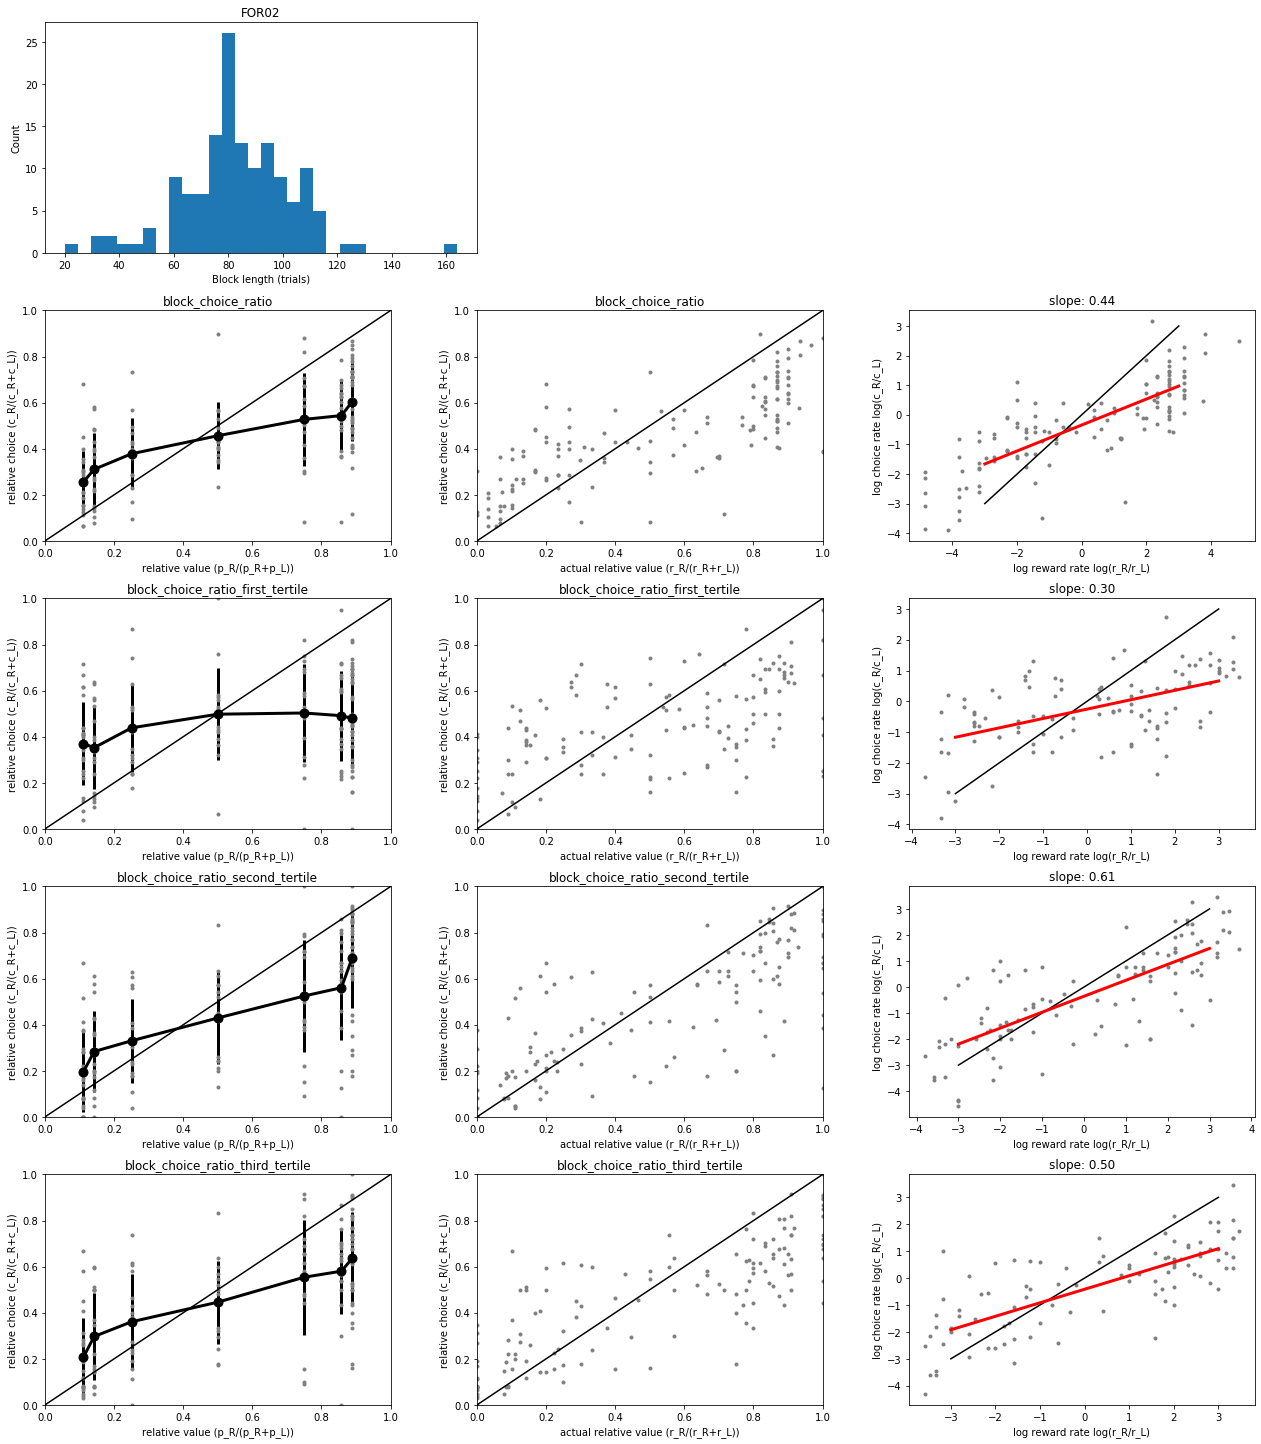

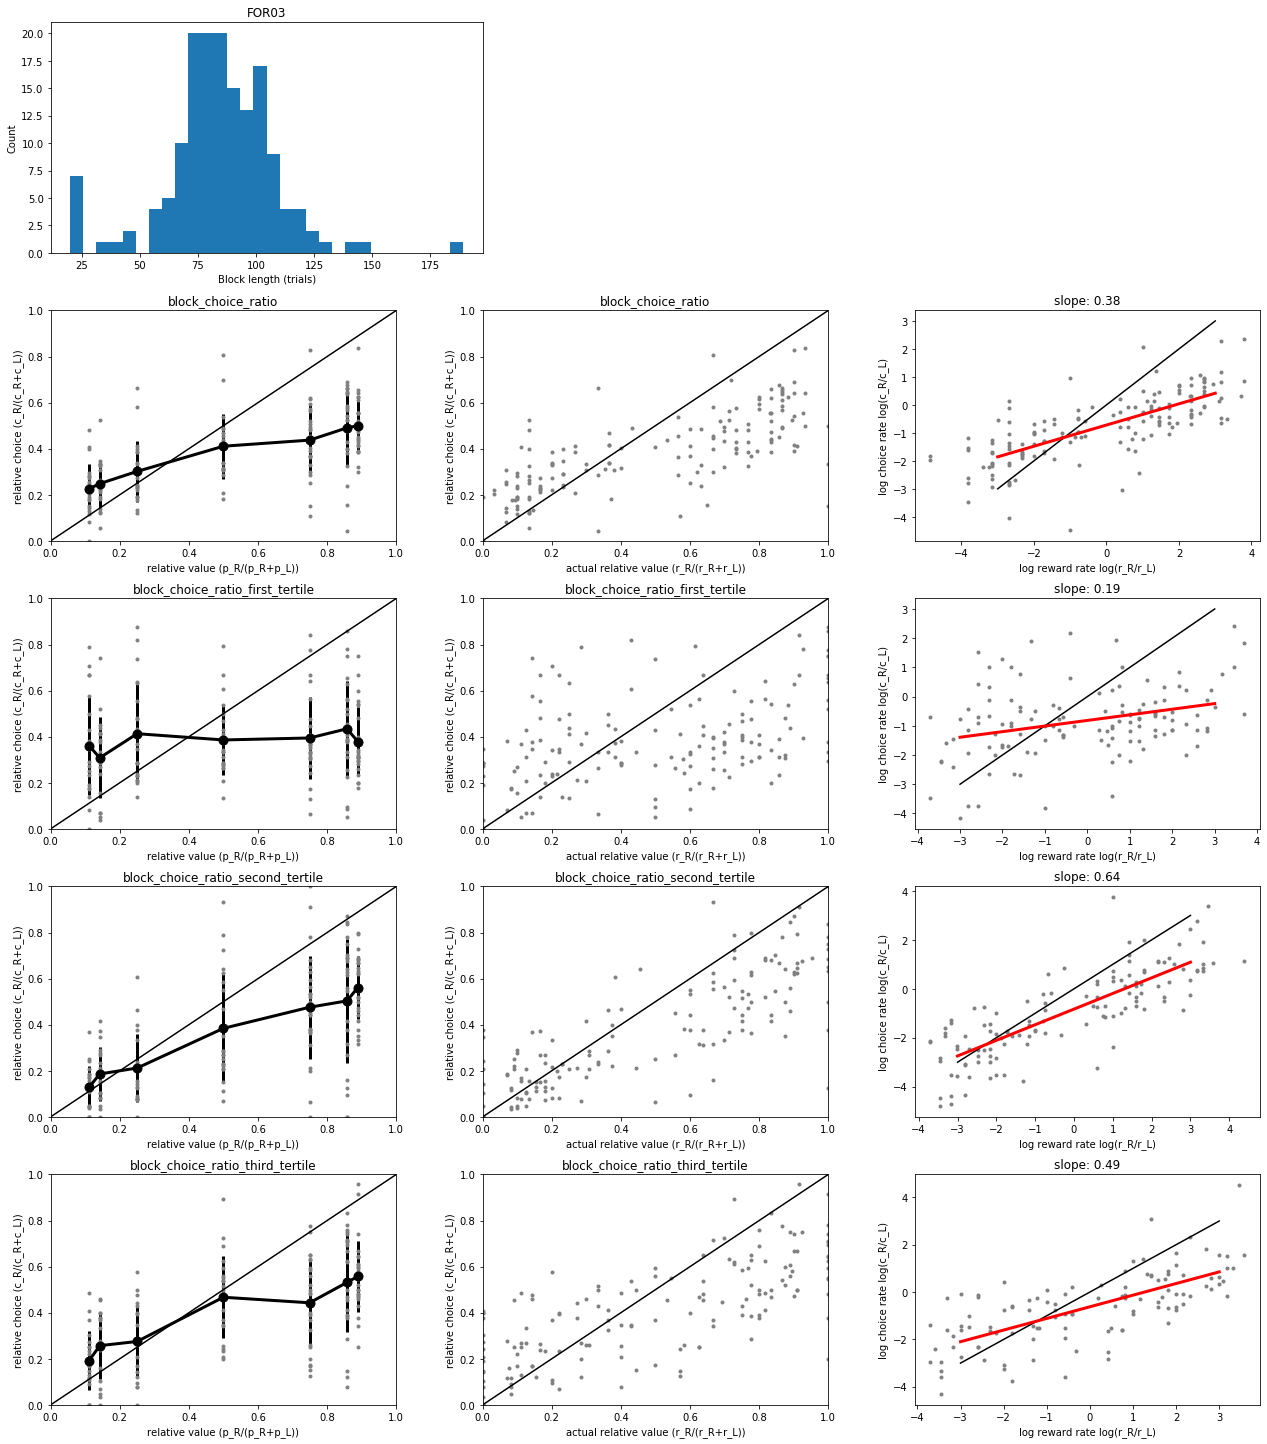

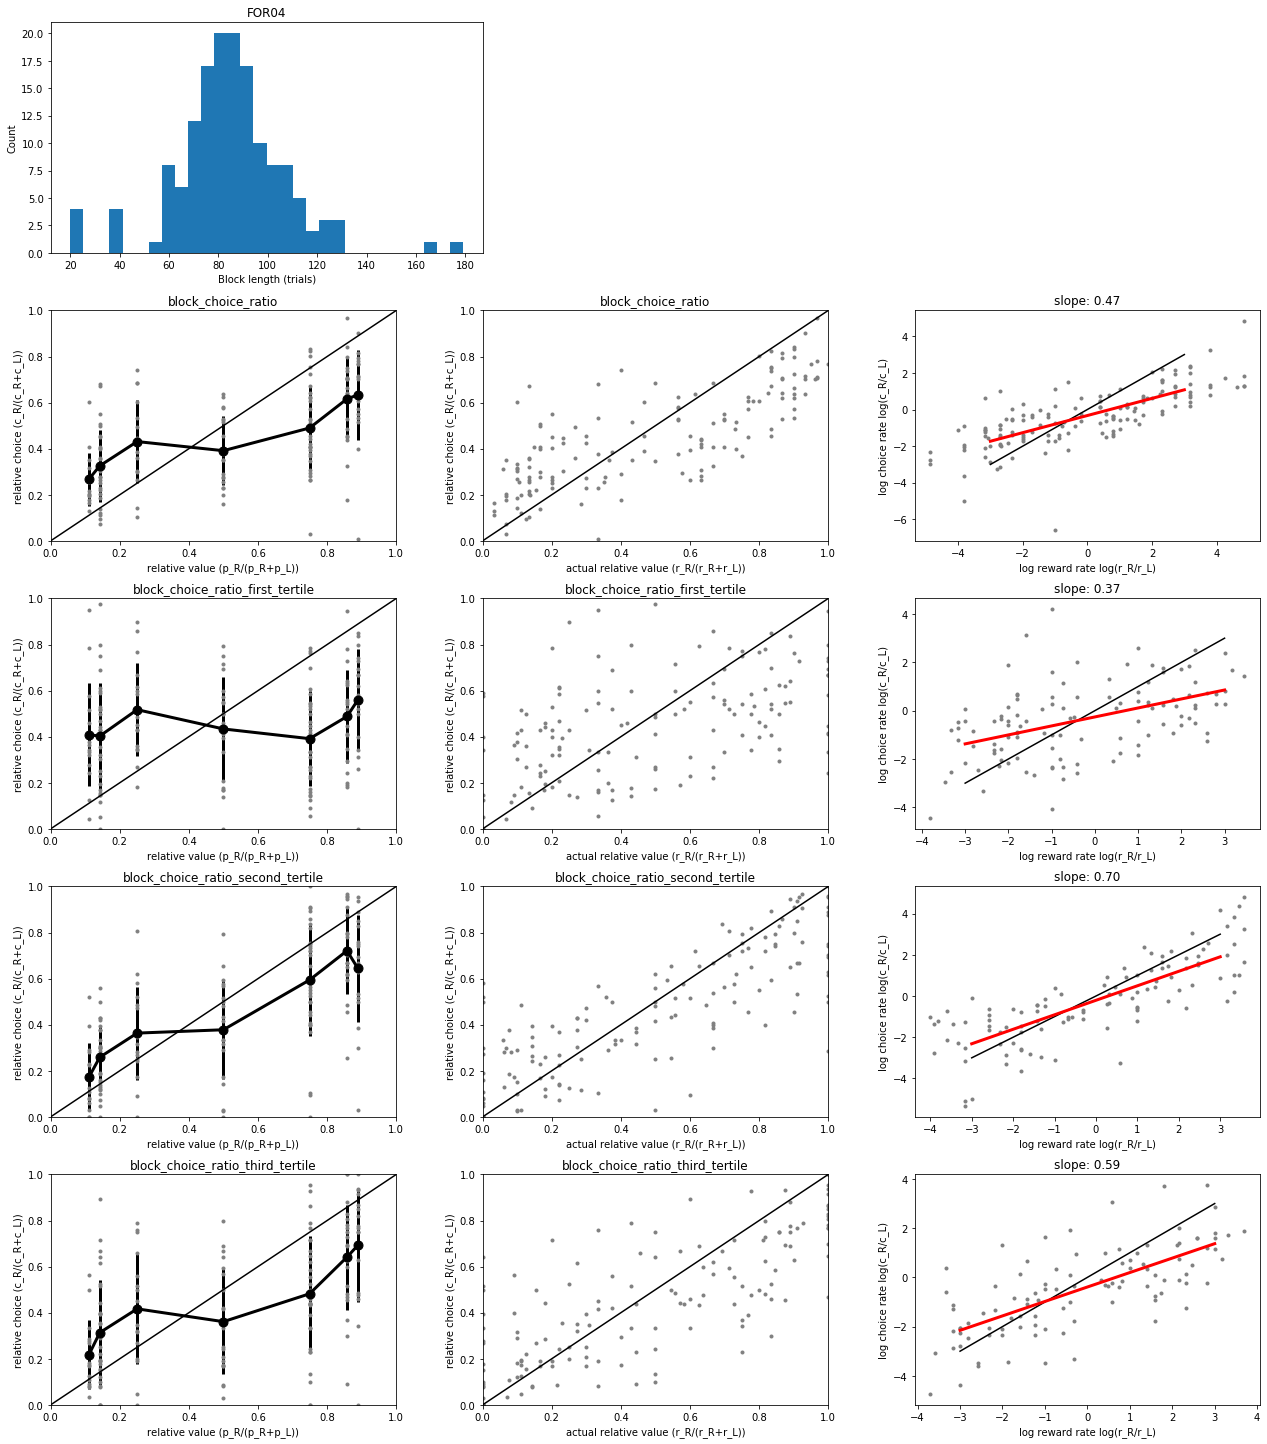

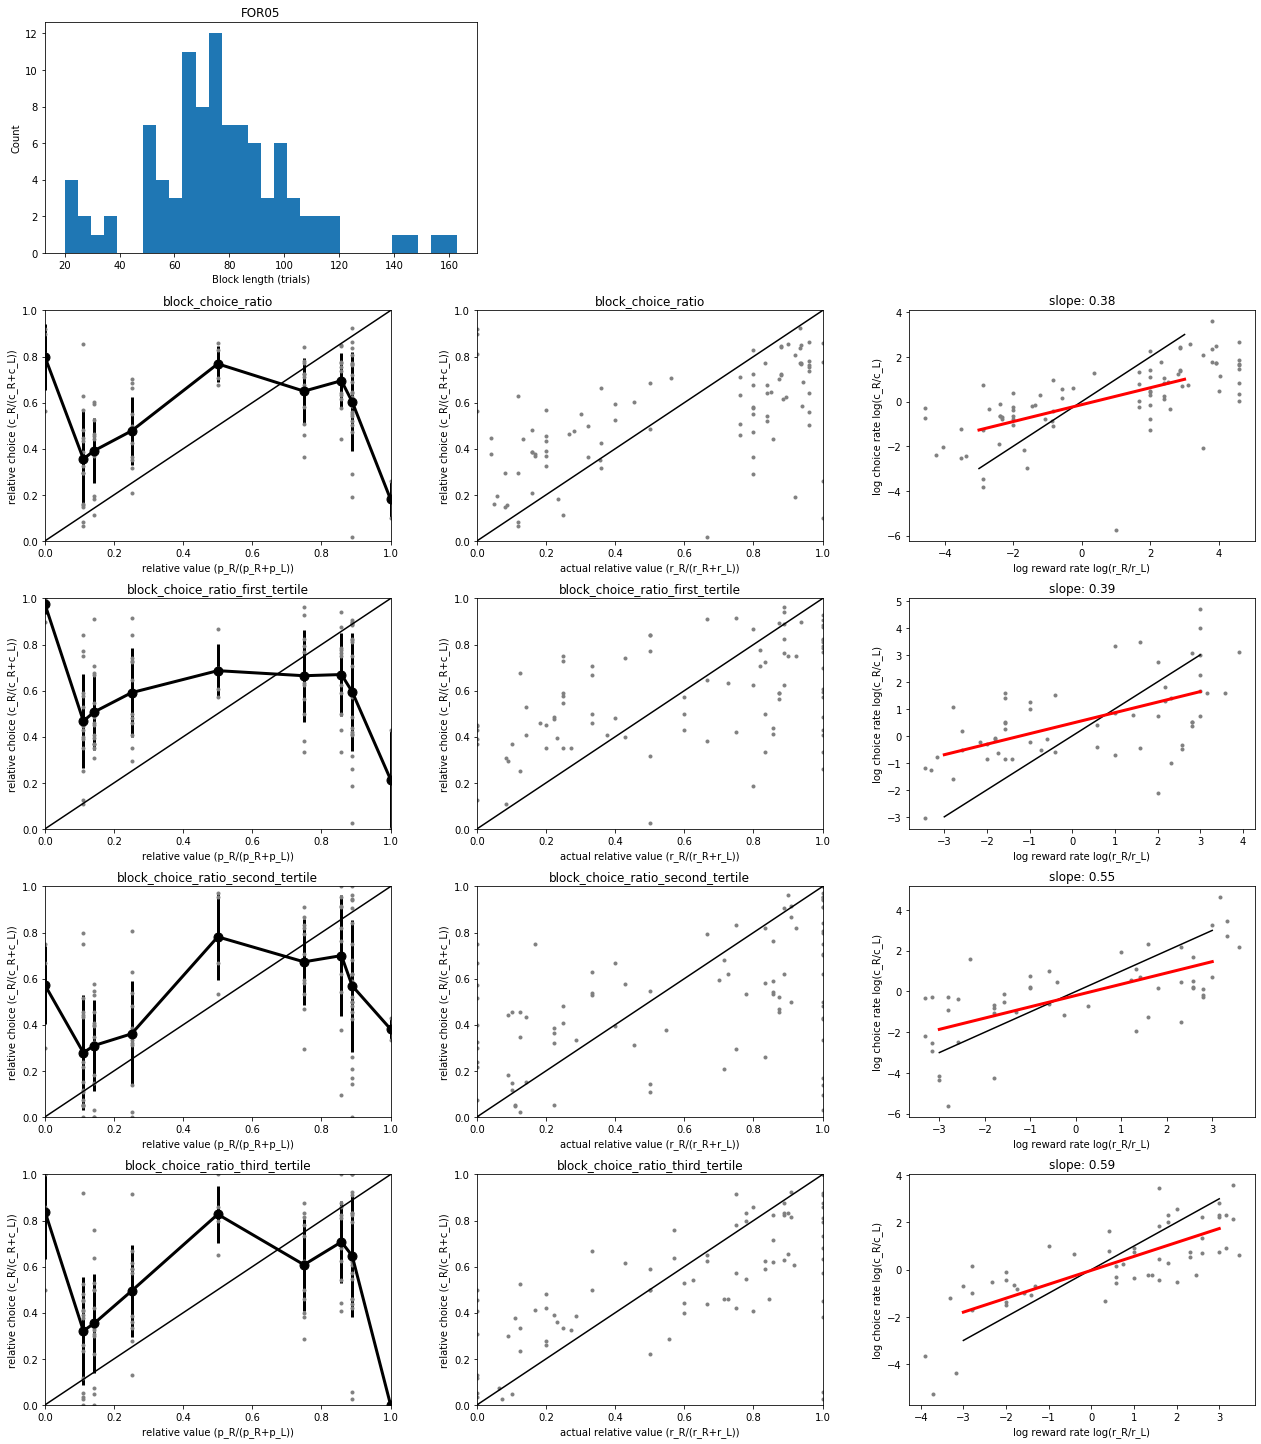

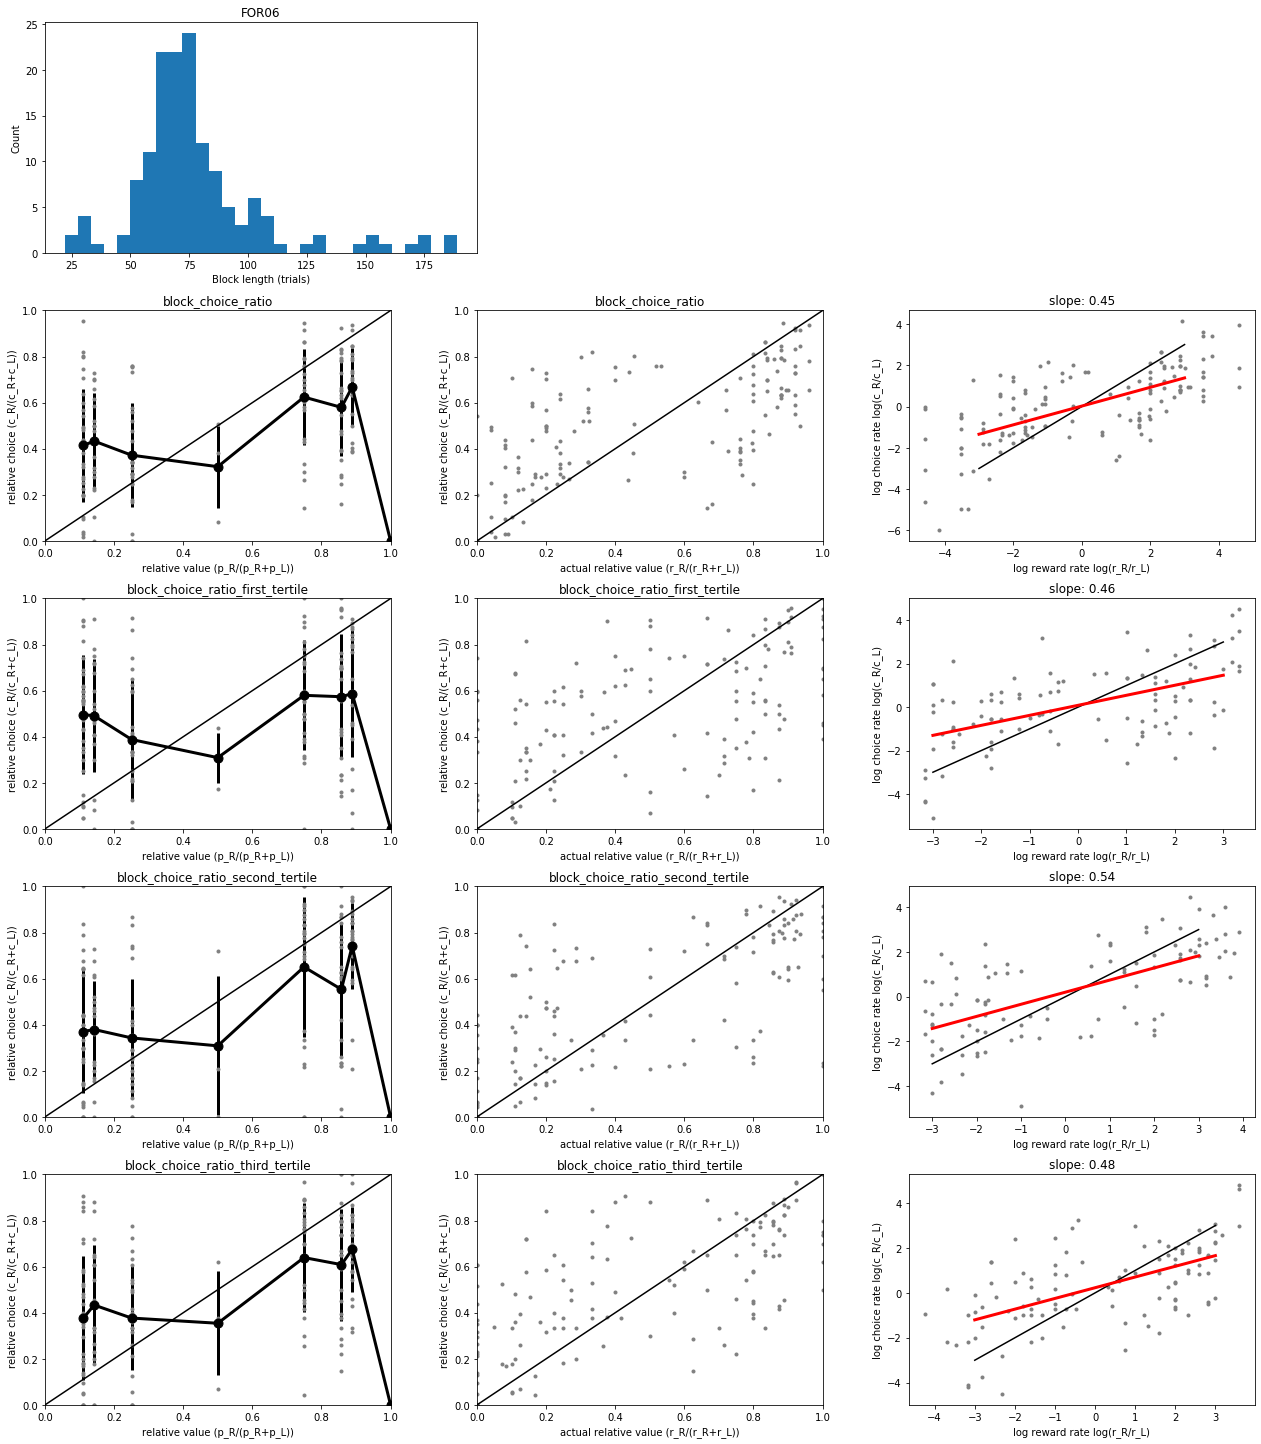

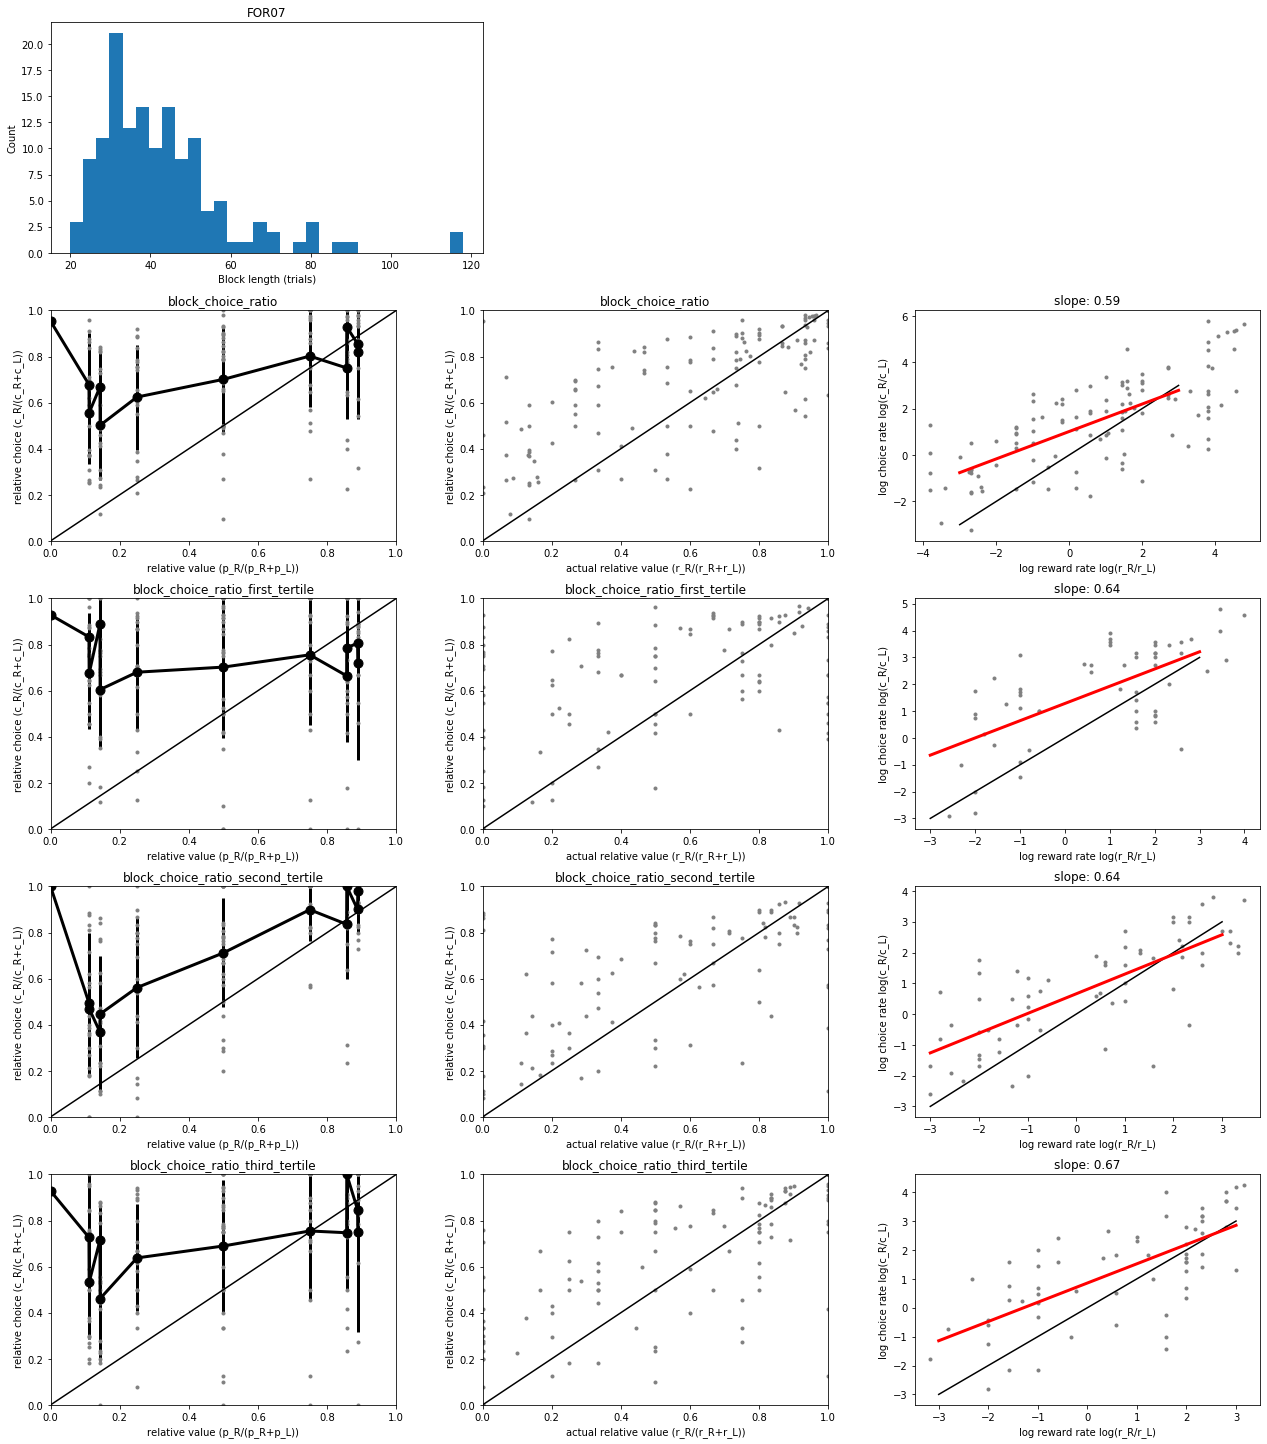

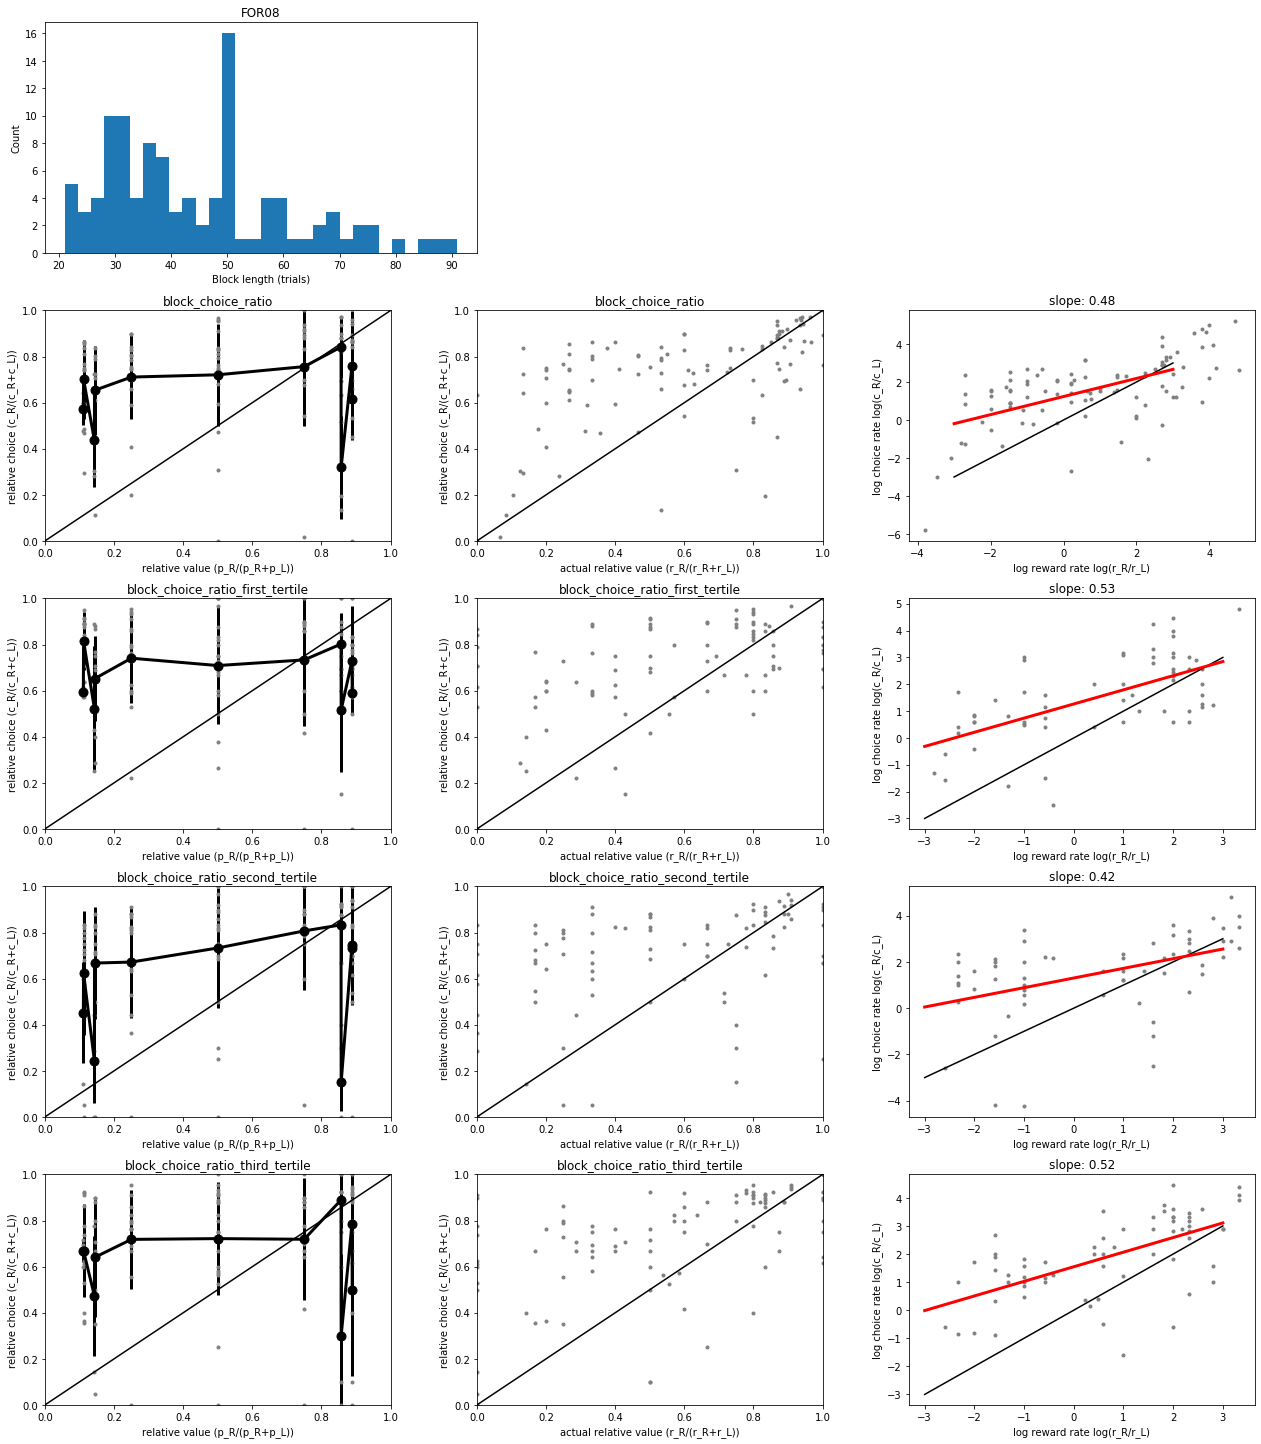

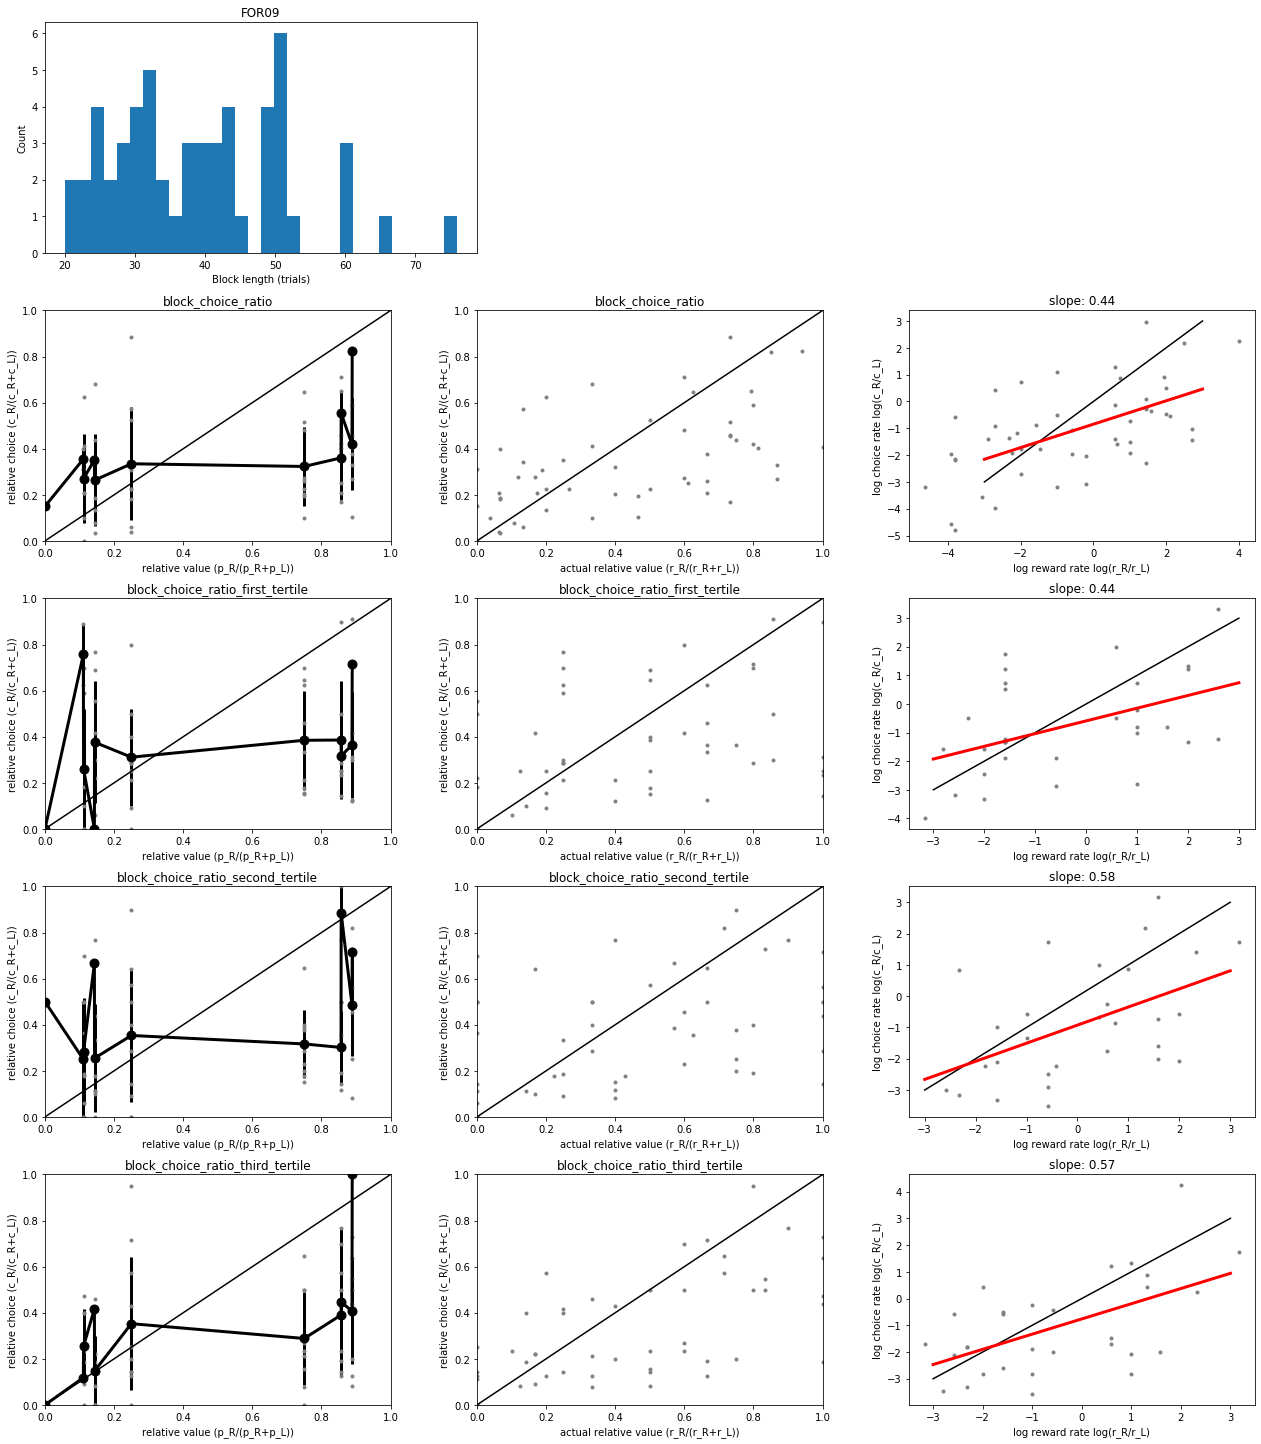

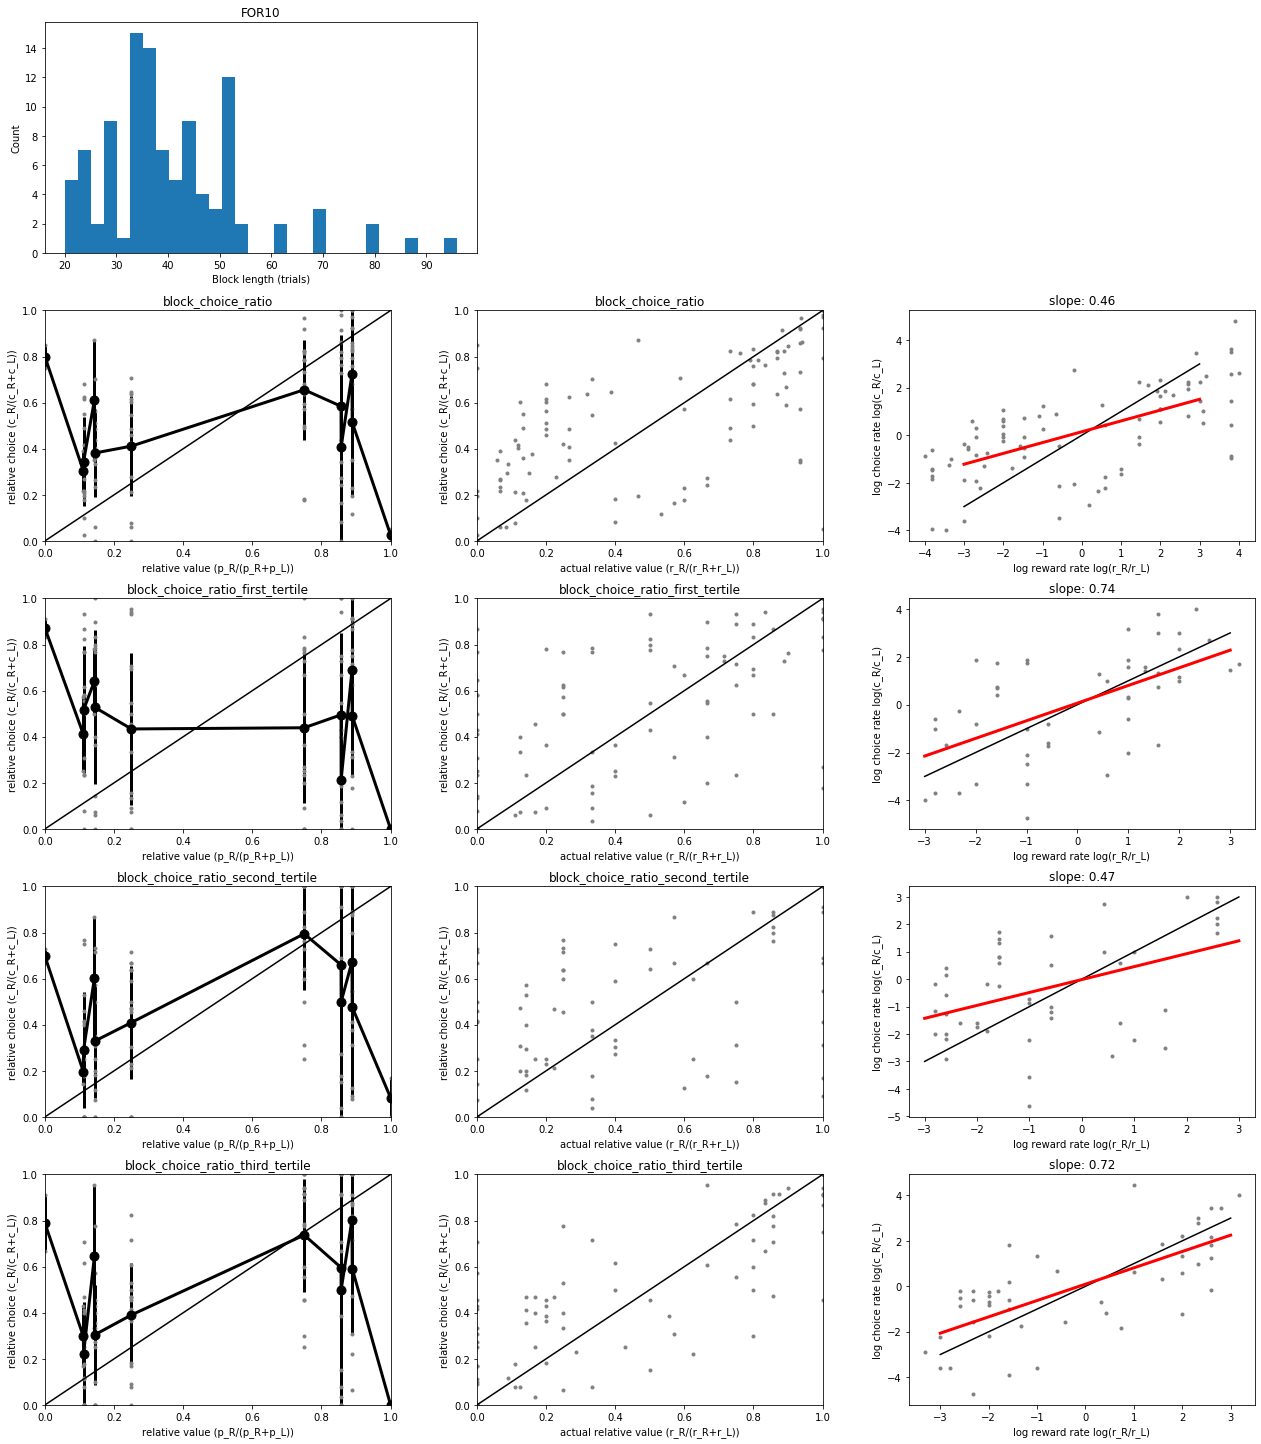

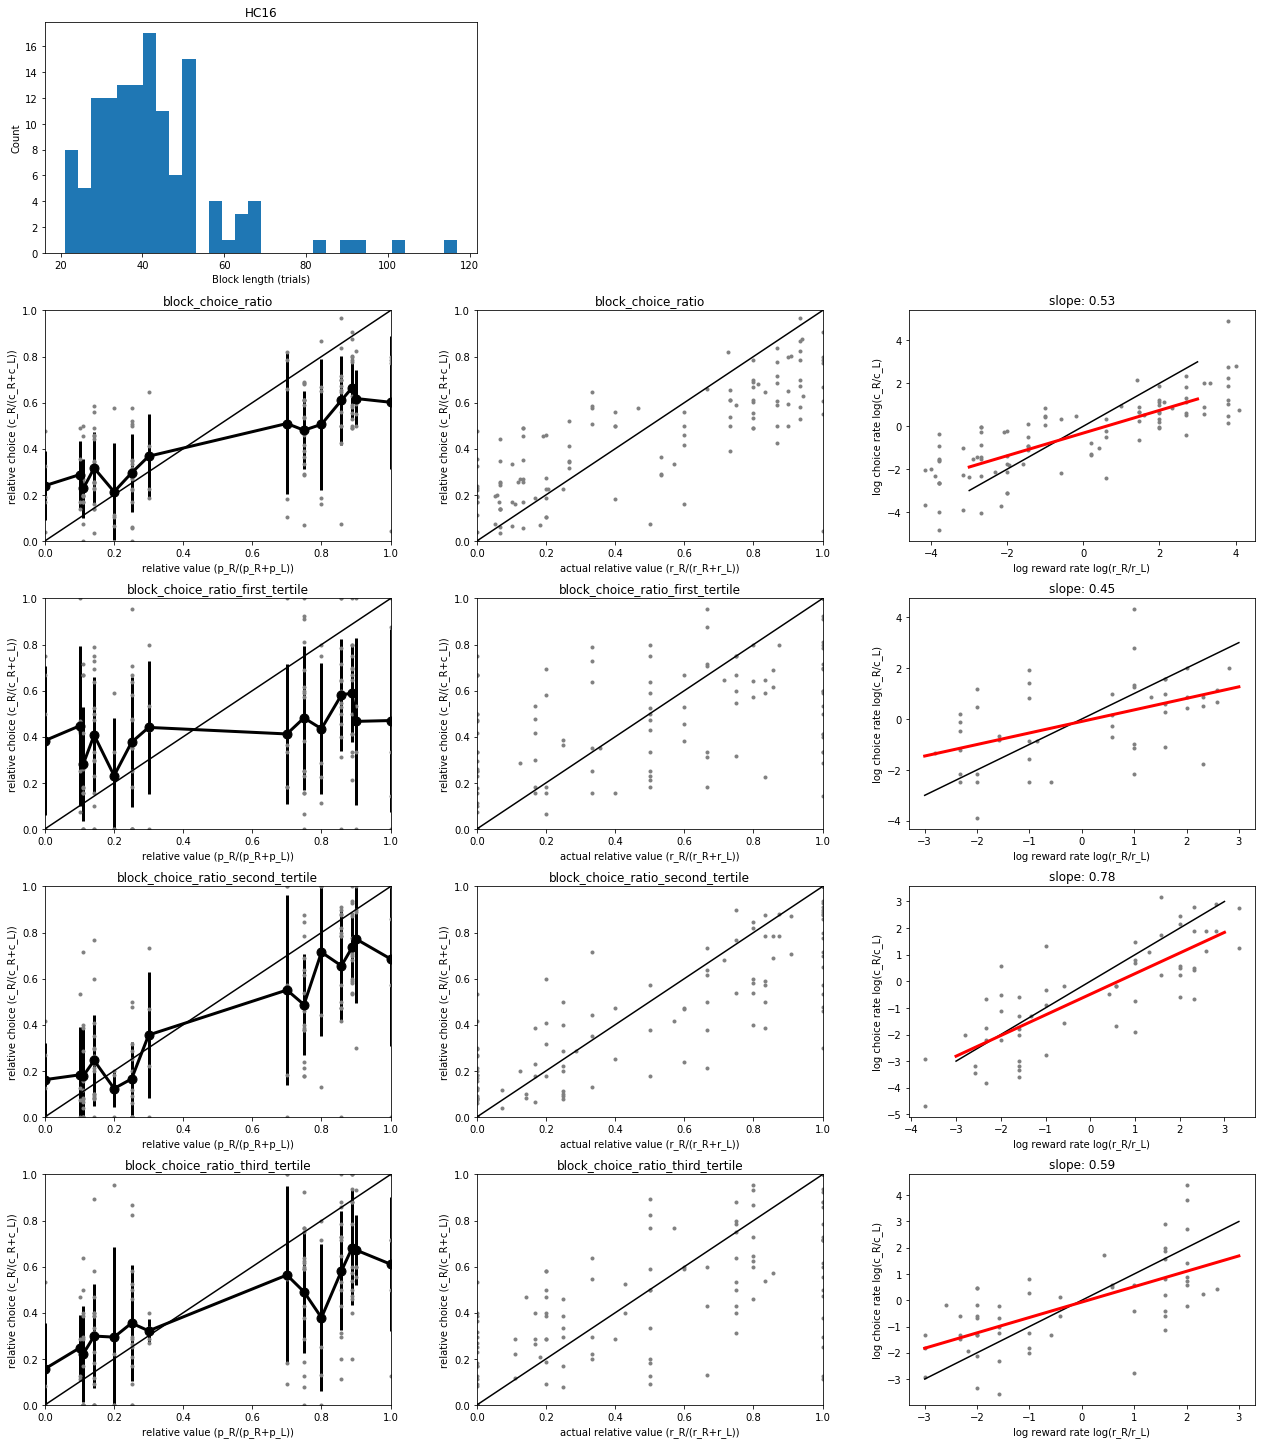

In [7]:
plot_block_based_tuning_curves(wr_name = 'FOR01')
plot_block_based_tuning_curves(wr_name = 'FOR02')
plot_block_based_tuning_curves(wr_name = 'FOR03')
plot_block_based_tuning_curves(wr_name = 'FOR04')
plot_block_based_tuning_curves(wr_name = 'FOR05')
plot_block_based_tuning_curves(wr_name = 'FOR06')
plot_block_based_tuning_curves(wr_name = 'FOR07')
plot_block_based_tuning_curves(wr_name = 'FOR08')
plot_block_based_tuning_curves(wr_name = 'FOR09')
plot_block_based_tuning_curves(wr_name = 'FOR10')
plot_block_based_tuning_curves(wr_name = 'HC16')



# Logistic regression for weeks 2-4

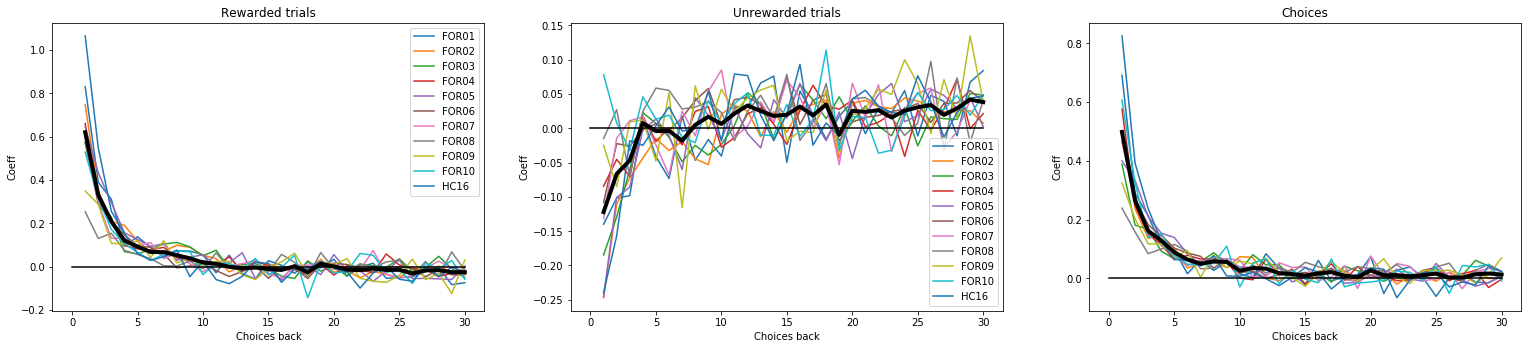

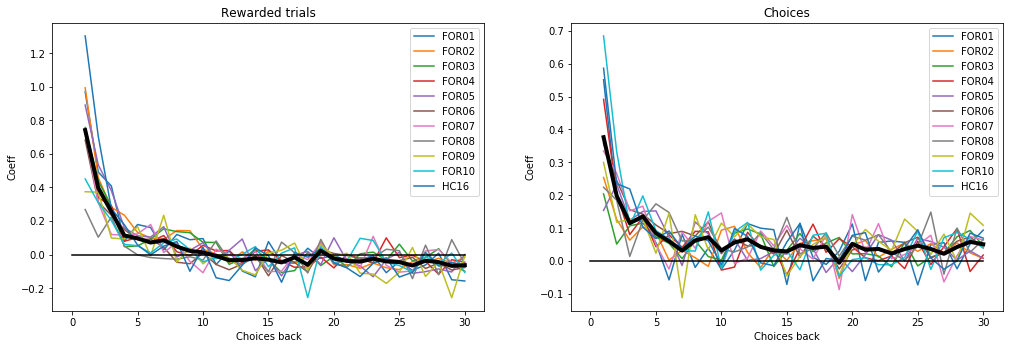

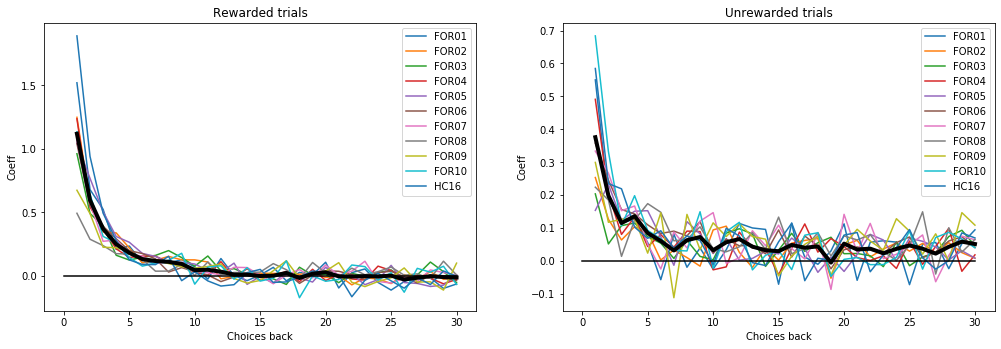

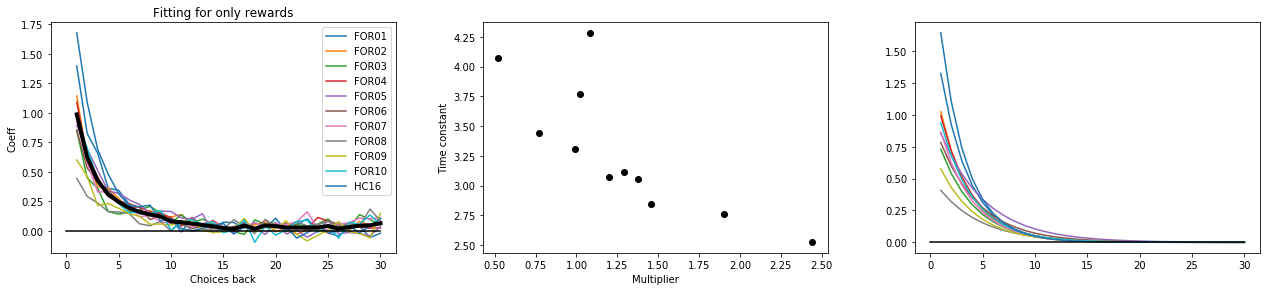

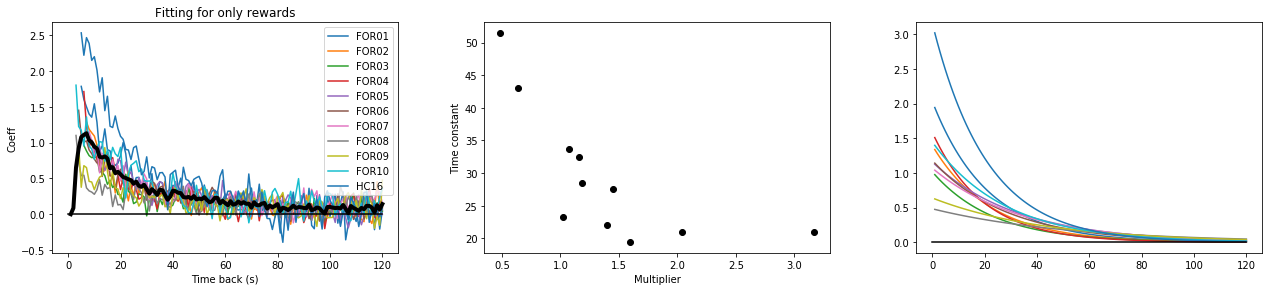

In [8]:
# rewarded unrewarded and choices
df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * experiment.SessionDetails)
subject_names = df_subject_wr['water_restriction_number'].unique()
subject_names.sort()
df_coeff = pd.DataFrame(behavioranal.SubjectFittedChoiceCoefficientsRNRC())
fig=plt.figure()
ax1=fig.add_axes([0,0,1,1])  
ax2=fig.add_axes([1.2,0,1,1]) 
ax3=fig.add_axes([2.4,0,1,1])
subject_names_legend = list()
for wr_name in subject_names:
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    idx = df_coeff['subject_id']==subject_id
    if sum(idx) == 1:
        ax1.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_rewards_subject'][idx].values[0])
        ax2.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_nonrewards_subject'][idx].values[0])
        ax3.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_choices_subject'][idx].values[0])
        
        subject_names_legend.append(wr_name)

ax1.set_xlabel('Choices back')
ax1.set_ylabel('Coeff')
ax1.set_title('Rewarded trials')
ax1.legend(subject_names)
ax2.set_xlabel('Choices back')
ax2.set_ylabel('Coeff')
ax2.set_title('Unrewarded trials')
ax3.set_xlabel('Choices back')
ax3.set_ylabel('Coeff')
ax3.set_title('Choices')
ax2.legend(subject_names_legend)
ax1.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_rewards_subject'].mean(),'k-',linewidth = 4)
ax2.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_nonrewards_subject'].mean(),'k-',linewidth = 4)
ax3.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_choices_subject'].mean(),'k-',linewidth = 4)
ax1.plot([0,len(df_coeff['coefficients_rewards_subject'].mean())],[0,0],'k-')
ax2.plot([0,len(df_coeff['coefficients_rewards_subject'].mean())],[0,0],'k-')
ax3.plot([0,len(df_coeff['coefficients_rewards_subject'].mean())],[0,0],'k-')
#template_1 = df_coeff['coefficients_rewards_subject'].mean()
#template_1[template_1<0]=0
#template_1 = template_1/sum(template_1)
#print(template_1)








# rewarded and choices
df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * experiment.SessionDetails)
subject_names = df_subject_wr['water_restriction_number'].unique()
subject_names.sort()
df_coeff = pd.DataFrame(behavioranal.SubjectFittedChoiceCoefficientsRC())
fig=plt.figure()
ax1=fig.add_axes([0,0,1,1])  
ax2=fig.add_axes([1.2,0,1,1]) 
subject_names_legend = list()
for wr_name in subject_names:
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    idx = df_coeff['subject_id']==subject_id
    if sum(idx) == 1:
        ax1.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_rewards_subject'][idx].values[0])
        ax2.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_choices_subject'][idx].values[0])
        subject_names_legend.append(wr_name)

ax1.set_xlabel('Choices back')
ax1.set_ylabel('Coeff')
ax1.set_title('Rewarded trials')
ax1.legend(subject_names)
ax2.set_xlabel('Choices back')
ax2.set_ylabel('Coeff')
ax2.set_title('Choices')
ax2.legend(subject_names_legend)
ax1.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_rewards_subject'].mean(),'k-',linewidth = 4)
ax2.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_choices_subject'].mean(),'k-',linewidth = 4)
ax1.plot([0,len(df_coeff['coefficients_rewards_subject'].mean())],[0,0],'k-')
ax2.plot([0,len(df_coeff['coefficients_rewards_subject'].mean())],[0,0],'k-')
#template_1 = df_coeff['coefficients_rewards_subject'].mean()
#template_1[template_1<0]=0
#template_1 = template_1/sum(template_1)
#print(template_1)

#rewarded and unrewarded
df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * experiment.SessionDetails)
subject_names = df_subject_wr['water_restriction_number'].unique()
subject_names.sort()
df_coeff = pd.DataFrame(behavioranal.SubjectFittedChoiceCoefficientsRNR())
fig=plt.figure()
ax1=fig.add_axes([0,0,1,1])  
ax2=fig.add_axes([1.2,0,1,1]) 
subject_names_legend = list()
for wr_name in subject_names:
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    idx = df_coeff['subject_id']==subject_id
    if sum(idx) == 1:
        ax1.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_rewards_subject'][idx].values[0])
        ax2.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_nonrewards_subject'][idx].values[0])
        subject_names_legend.append(wr_name)

ax1.set_xlabel('Choices back')
ax1.set_ylabel('Coeff')
ax1.set_title('Rewarded trials')
ax1.legend(subject_names)
ax2.set_xlabel('Choices back')
ax2.set_ylabel('Coeff')
ax2.set_title('Unrewarded trials')
ax2.legend(subject_names_legend)
ax1.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_rewards_subject'].mean(),'k-',linewidth = 4)
ax2.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_nonrewards_subject'].mean(),'k-',linewidth = 4)
ax1.plot([0,len(df_coeff['coefficients_rewards_subject'].mean())],[0,0],'k-')
ax2.plot([0,len(df_coeff['coefficients_rewards_subject'].mean())],[0,0],'k-')
#template_1 = df_coeff['coefficients_rewards_subject'].mean()
#template_1[template_1<0]=0
#template_1 = template_1/sum(template_1)
#print(template_1)

#% only rewarded
df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * experiment.SessionDetails)
subject_names = df_subject_wr['water_restriction_number'].unique()
subject_names.sort()
df_coeff = pd.DataFrame(behavioranal.SubjectFittedChoiceCoefficientsOnlyRewards())
fig=plt.figure()
ax1=fig.add_axes([0,0,.8,.8])  
ax11=fig.add_axes([1,0,.8,.8])  
ax111=fig.add_axes([2,0,.8,.8])  
subject_names_legend = list()
param_a = list()
param_b = list()
for wr_name in subject_names:
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    idx = df_coeff['subject_id']==subject_id
    if sum(idx) == 1:
        ax1.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_rewards_subject'][idx].values[0])
        subject_names_legend.append(wr_name)
        try:
            out = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(-t/b),  list(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1)),  df_coeff['coefficients_rewards_subject'][idx].values[0])
        except:
            out = list()
        if len(out)>0:
            param_a.append(out[0][0])
            param_b.append(out[0][1])
            xvals = np.asarray(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1))
            yvals = out[0][0]*np.exp(-xvals/out[0][1])
            ax111.plot(xvals,yvals)    

            
ax11.plot(param_a,param_b,'ko')
ax11.set_xlabel('Multiplier')
ax11.set_ylabel('Time constant')
ax1.set_xlabel('Choices back')
ax1.set_ylabel('Coeff')
ax1.set_title('Fitting for only rewards')
ax1.legend(subject_names_legend)
ax1.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_rewards_subject'].mean(),'k-',linewidth = 4)
ax1.plot([0,len(df_coeff['coefficients_rewards_subject'].mean())],[0,0],'k-')

ax111.plot([0,len(df_coeff['coefficients_rewards_subject'].mean())],[0,0],'k-')
#template_2 = df_coeff['coefficients_rewards_subject'].mean()
#template_2[template_2<0]=0
#template_2 = template_2/sum(template_2)
#print(template_2)





#%only rewarded vs time
df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * experiment.SessionDetails)
subject_names = df_subject_wr['water_restriction_number'].unique()
subject_names.sort()
df_coeff = pd.DataFrame(behavioranal.SubjectFittedChoiceCoefficientsVSTime())
fig=plt.figure()
ax1=fig.add_axes([0,0,.8,.8])  
ax11=fig.add_axes([1,0,.8,.8])  
ax111=fig.add_axes([2,0,.8,.8]) 
subject_names_legend = list()
param_a = list()
param_b = list()
for wr_name in subject_names:
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    idx = df_coeff['subject_id']==subject_id
    if sum(idx) == 1:
        #ax1.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_rewards_subject'][idx].values[0])
        subject_names_legend.append(wr_name)
        try:
            x = list(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1))
            y = df_coeff['coefficients_rewards_subject'][idx].values[0]
            start = y.argmax()
            x = x[start:]
            y = y[start:]
            ax1.plot(x,y)
            out = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(-t/b),  x,  y)
        except:
            out = list()
        if len(out)>0:
            param_a.append(out[0][0])
            param_b.append(out[0][1])
            xvals = np.asarray(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1))
            yvals = out[0][0]*np.exp(-xvals/out[0][1])
            ax111.plot(xvals,yvals)    

            
ax11.plot(param_a,param_b,'ko')
ax11.set_xlabel('Multiplier')
ax11.set_ylabel('Time constant')

ax1.set_xlabel('Time back (s)')
ax1.set_ylabel('Coeff')
ax1.set_title('Fitting for only rewards')
ax1.legend(subject_names_legend)
ax1.plot(range(1,len(df_coeff['coefficients_rewards_subject'].mean())+1),df_coeff['coefficients_rewards_subject'].mean(),'k-',linewidth = 4)
ax1.plot([0,len(df_coeff['coefficients_rewards_subject'].mean())],[0,0],'k-')
ax111.plot([0,len(df_coeff['coefficients_rewards_subject'].mean())],[0,0],'k-')

#template_2 = df_coeff['coefficients_rewards_subject'].mean()
#template_2[template_2<0]=0
#template_2 = template_2/sum(template_2)
#print(template_2)


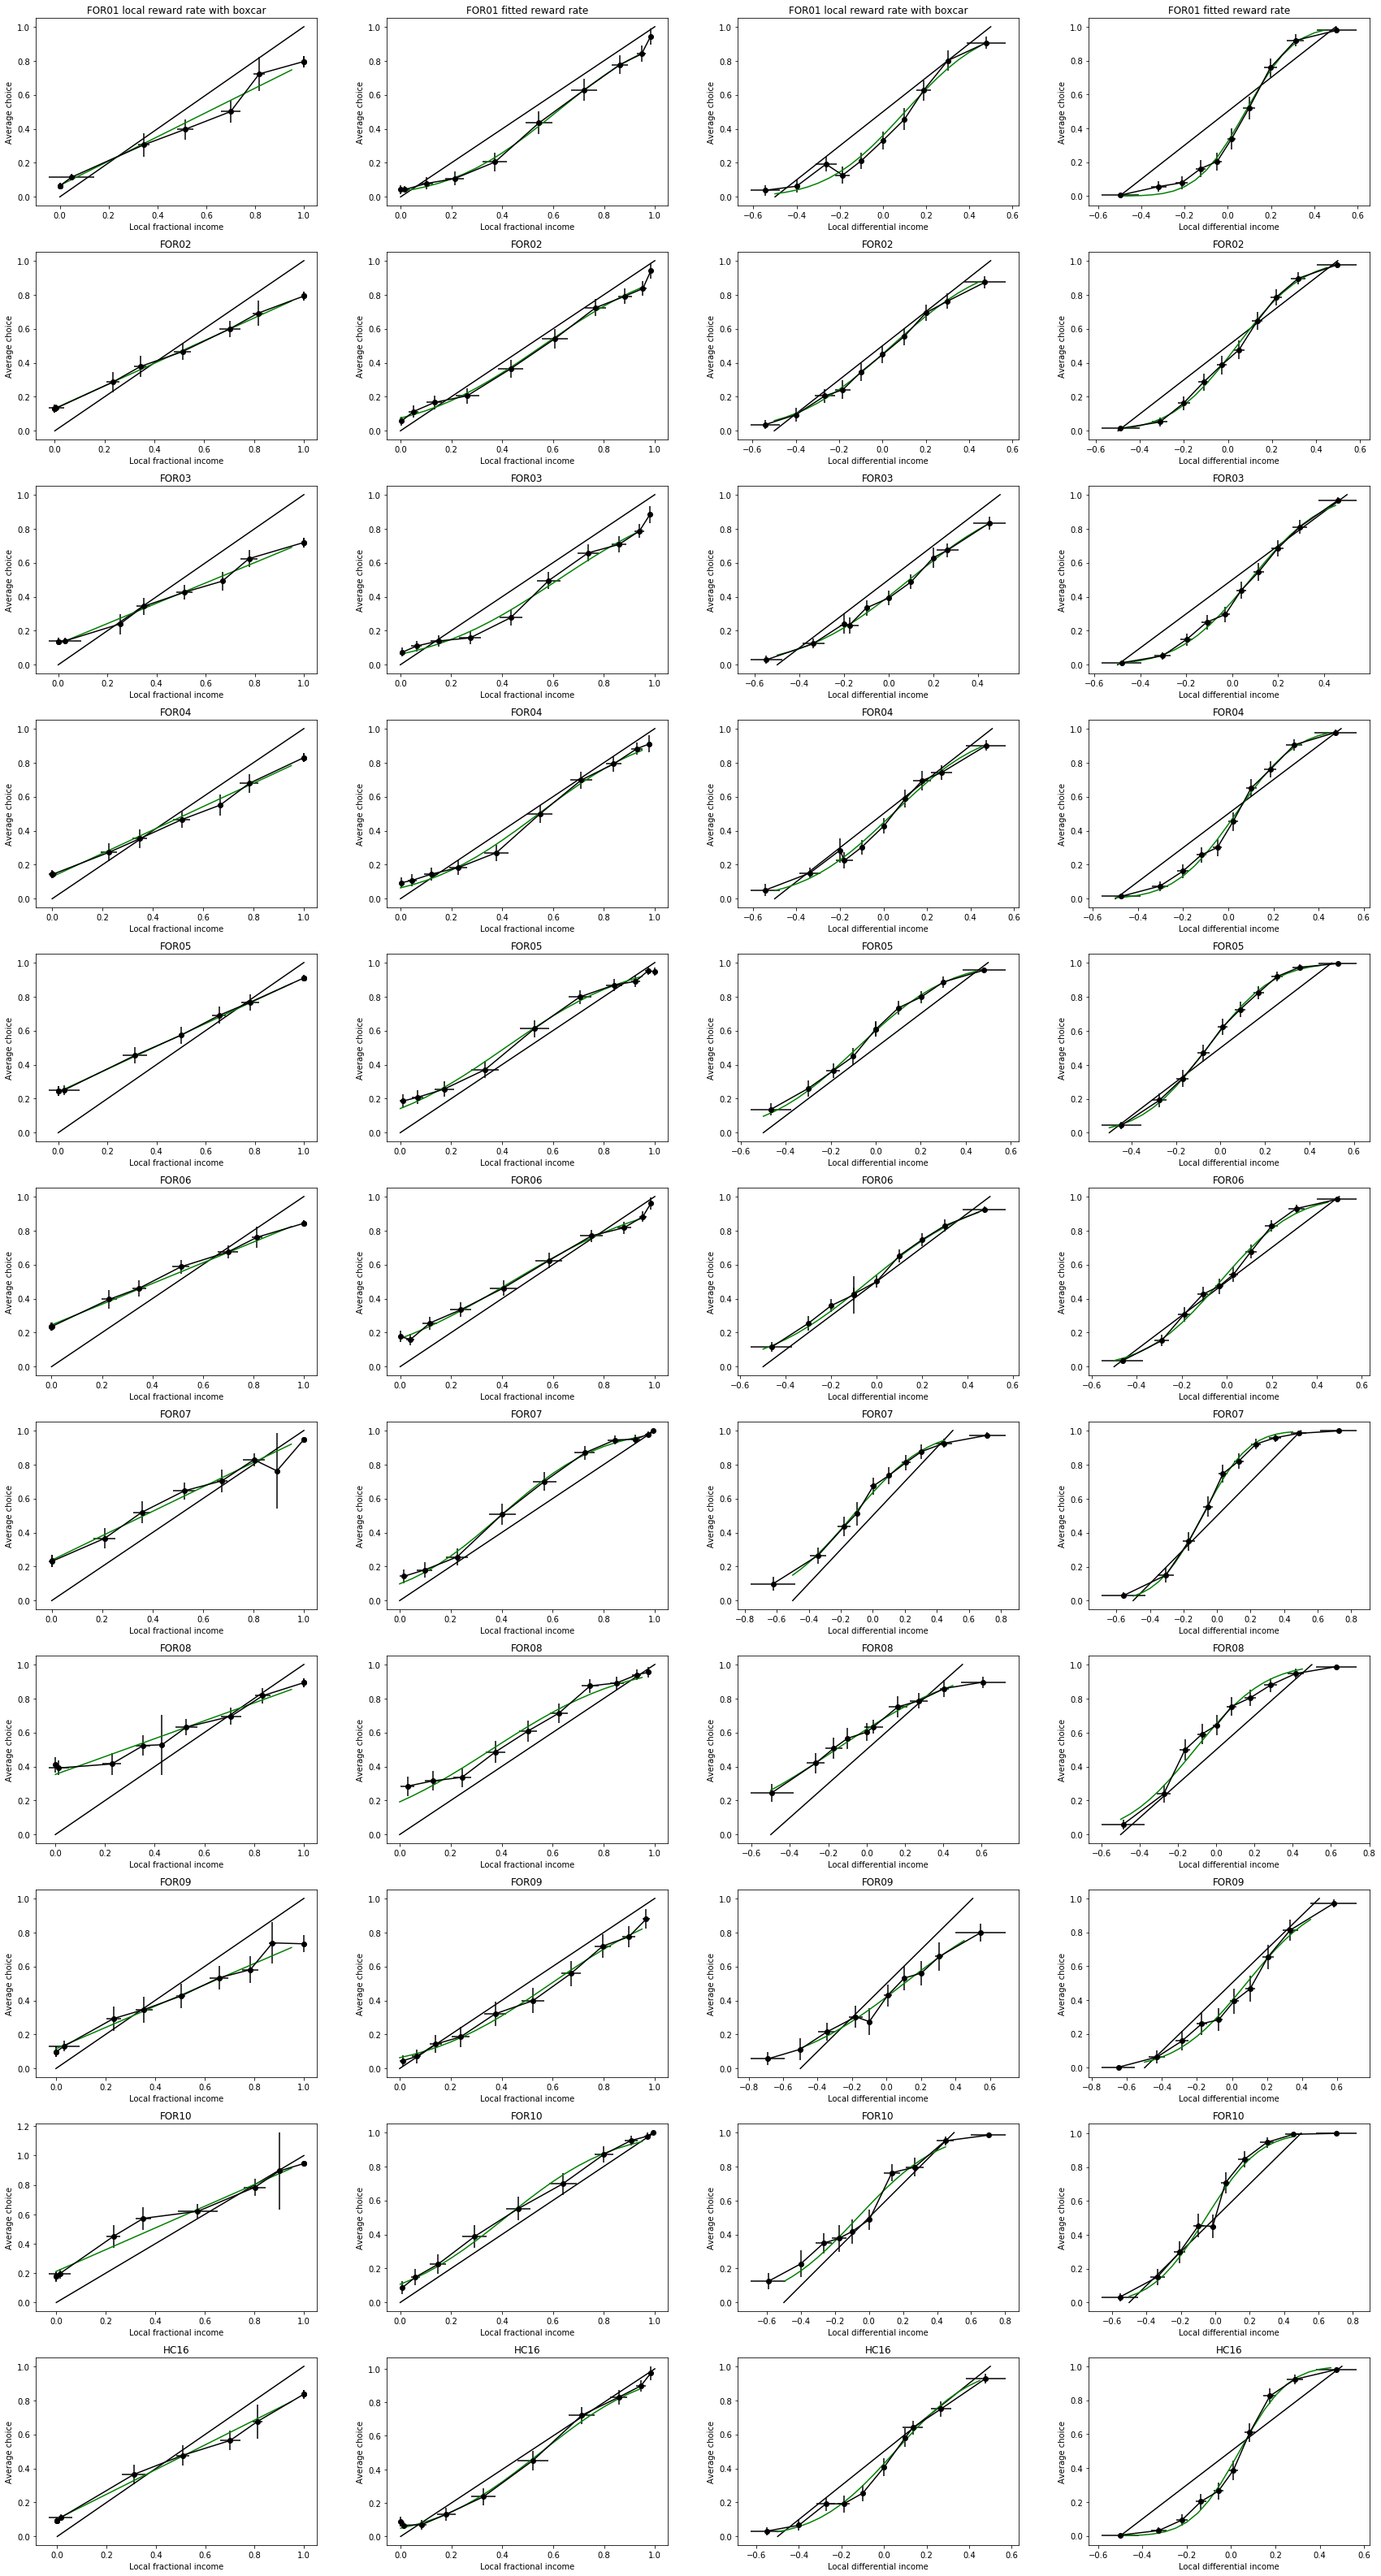

In [9]:
df_psych_boxcar = pd.DataFrame(lab.WaterRestriction()*behavioranal.SubjectPsychometricCurveBoxCarFractional())
df_psych_fitted = pd.DataFrame(lab.WaterRestriction()*behavioranal.SubjectPsychometricCurveFittedFractional())
df_psych_boxcar_diff = pd.DataFrame(lab.WaterRestriction()*behavioranal.SubjectPsychometricCurveBoxCarDifferential())
df_psych_fitted_diff = pd.DataFrame(lab.WaterRestriction()*behavioranal.SubjectPsychometricCurveFittedDifferential())
fig=plt.figure()
axes = list()
for i,wrname in enumerate(np.sort(df_psych_boxcar['water_restriction_number'].values)):
    idx = np.where(df_psych_boxcar['water_restriction_number'] == wrname)[0][0]
    axes.append(fig.add_axes([0,-i,.8,.8]))
    axes[-1].plot([0,1],[0,1],'k-') 
    axes[-1].errorbar(df_psych_boxcar['reward_ratio_mean'][idx],df_psych_boxcar['choice_ratio_mean'][idx],df_psych_boxcar['choice_ratio_sd'][idx],df_psych_boxcar['reward_ratio_sd'][idx],'ko-') 
    if i == 0:
        axes[-1].set_title(wrname+' local reward rate with boxcar')
    else:
        axes[-1].set_title(wrname)
    x_sigmoid = np.arange(0,1,.05)
    y_sigmoid = norm.cdf(x_sigmoid, df_psych_boxcar['sigmoid_fit_mu'][idx], df_psych_boxcar['sigmoid_fit_sigma'][idx])
    x_linear = np.arange(0,1,.05)
    y_linear = x_linear * df_psych_boxcar['linear_fit_slope'][idx] + df_psych_boxcar['linear_fit_c'][idx]
    axes[-1].plot(x_linear,y_linear,'g-')
    axes[-1].set_xlabel('Local fractional income')
    axes[-1].set_ylabel('Average choice')
for i,wrname in enumerate(np.sort(df_psych_fitted['water_restriction_number'].values)):
    idx = np.where(df_psych_fitted['water_restriction_number'] == wrname)[0][0]
    axes.append(fig.add_axes([1,-i,.8,.8]))
    axes[-1].plot([0,1],[0,1],'k-') 
    axes[-1].errorbar(df_psych_fitted['reward_ratio_mean'][idx],df_psych_fitted['choice_ratio_mean'][idx],df_psych_fitted['choice_ratio_sd'][idx],df_psych_fitted['reward_ratio_sd'][idx],'ko-') 
    if i == 0:
        axes[-1].set_title(wrname+' fitted reward rate')
    else:
        axes[-1].set_title(wrname)
    x_sigmoid = np.arange(0,1,.05)
    y_sigmoid = norm.cdf(x_sigmoid, df_psych_fitted['sigmoid_fit_mu'][idx], df_psych_fitted['sigmoid_fit_sigma'][idx])
    x_linear = np.arange(0,1,.05)
    y_linear = x_linear * df_psych_boxcar['linear_fit_slope'][idx] + df_psych_boxcar['linear_fit_c'][idx]
    #axes[-1].plot(x_linear,y_linear,'g-')
    axes[-1].plot(x_sigmoid,y_sigmoid,'g-')
    axes[-1].set_xlabel('Local fractional income')
    axes[-1].set_ylabel('Average choice')
    
for i,wrname in enumerate(np.sort(df_psych_boxcar_diff['water_restriction_number'].values)):
    idx = np.where(df_psych_boxcar_diff['water_restriction_number'] == wrname)[0][0]
    axes.append(fig.add_axes([2,-i,.8,.8]))
    axes[-1].plot([-.5,.5],[0,1],'k-') 
    axes[-1].errorbar(df_psych_boxcar_diff['reward_ratio_mean'][idx],df_psych_boxcar_diff['choice_ratio_mean'][idx],df_psych_boxcar_diff['choice_ratio_sd'][idx],df_psych_boxcar_diff['reward_ratio_sd'][idx],'ko-') 
    if i == 0:
        axes[-1].set_title(wrname+' local reward rate with boxcar')
    else:
        axes[-1].set_title(wrname)
    x_sigmoid = np.arange(-.5,.5,.05)
    y_sigmoid = norm.cdf(x_sigmoid, df_psych_boxcar_diff['sigmoid_fit_mu'][idx], df_psych_boxcar_diff['sigmoid_fit_sigma'][idx])
    axes[-1].plot(x_sigmoid,y_sigmoid,'g-')        
    axes[-1].set_xlabel('Local differential income')
    axes[-1].set_ylabel('Average choice')
for i,wrname in enumerate(np.sort(df_psych_fitted_diff['water_restriction_number'].values)):
    idx = np.where(df_psych_fitted_diff['water_restriction_number'] == wrname)[0][0]
    axes.append(fig.add_axes([3,-i,.8,.8]))
    axes[-1].plot([-.5,.5],[0,1],'k-') 
    axes[-1].errorbar(df_psych_fitted_diff['reward_ratio_mean'][idx],df_psych_fitted_diff['choice_ratio_mean'][idx],df_psych_fitted_diff['choice_ratio_sd'][idx],df_psych_fitted_diff['reward_ratio_sd'][idx],'ko-') 
    if i == 0:
        axes[-1].set_title(wrname+' fitted reward rate')
    else:
        axes[-1].set_title(wrname)
    x_sigmoid = np.arange(-.5,.5,.05)
    y_sigmoid = norm.cdf(x_sigmoid, df_psych_fitted_diff['sigmoid_fit_mu'][idx], df_psych_fitted_diff['sigmoid_fit_sigma'][idx])
    axes[-1].plot(x_sigmoid,y_sigmoid,'g-')                
    axes[-1].set_xlabel('Local differential income')
    axes[-1].set_ylabel('Average choice')

# Display last session:

In [4]:
model = 'fitted fractional'
plot_one_session(wr_name = 'FOR01',session = 'last',model = model)
plot_one_session(wr_name = 'FOR02',session = 'last',model = model)
plot_one_session(wr_name = 'FOR03',session = 'last',model = model)
plot_one_session(wr_name = 'FOR04',session = 'last',model = model)
plot_one_session(wr_name = 'FOR05',session = 'last',model = model)
plot_one_session(wr_name = 'FOR06',session = 'last',model = model)
plot_one_session(wr_name = 'FOR07',session = 'last',model = model)
plot_one_session(wr_name = 'FOR08',session = 'last',model = model)
plot_one_session(wr_name = 'FOR09',session = 'last',model = model)
plot_one_session(wr_name = 'FOR10',session = 'last',model = model)

LostConnectionError: Server connection lost due to an interface error.

## model = 'fitted fractional'
plot_one_session(wr_name = 'HC16',session = 24,model = model)

Behavior on block switches for all animals

453478
453475
453477
453476


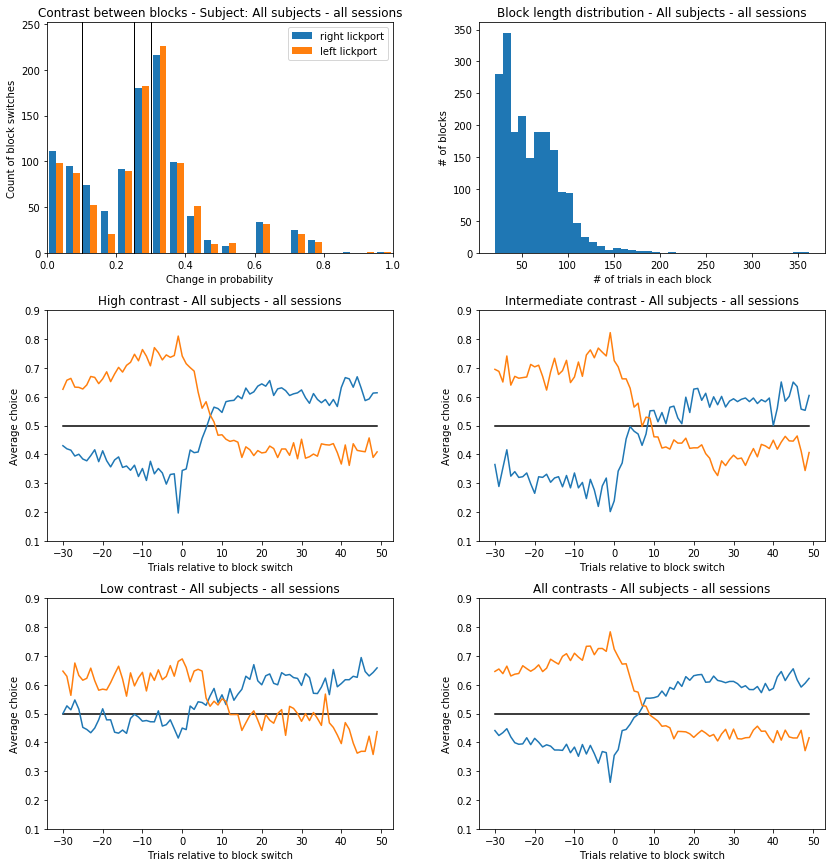

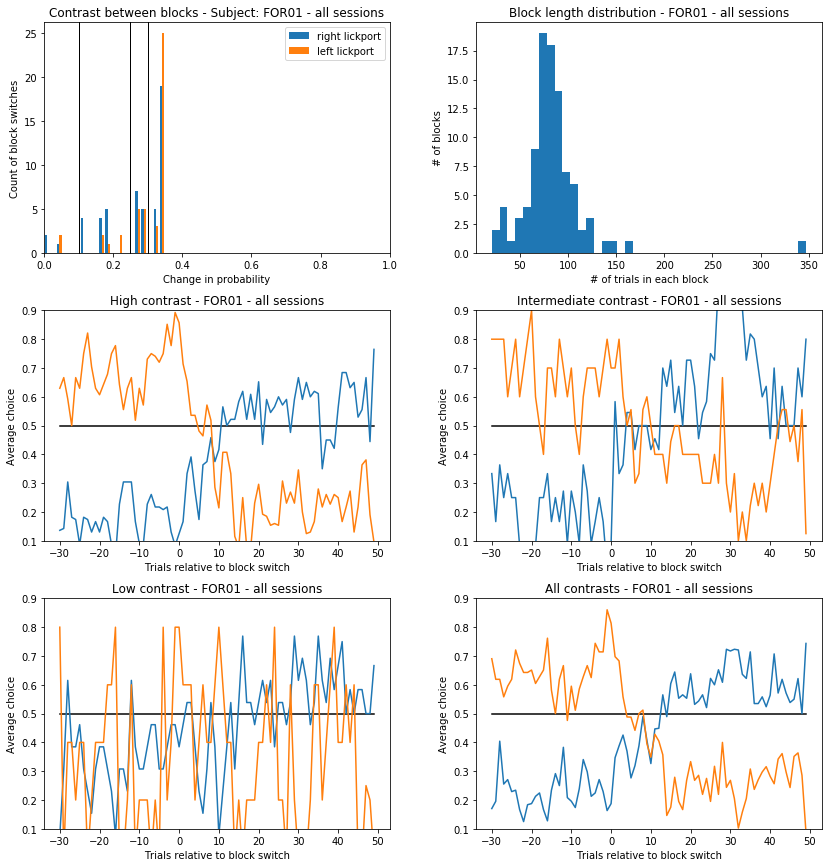

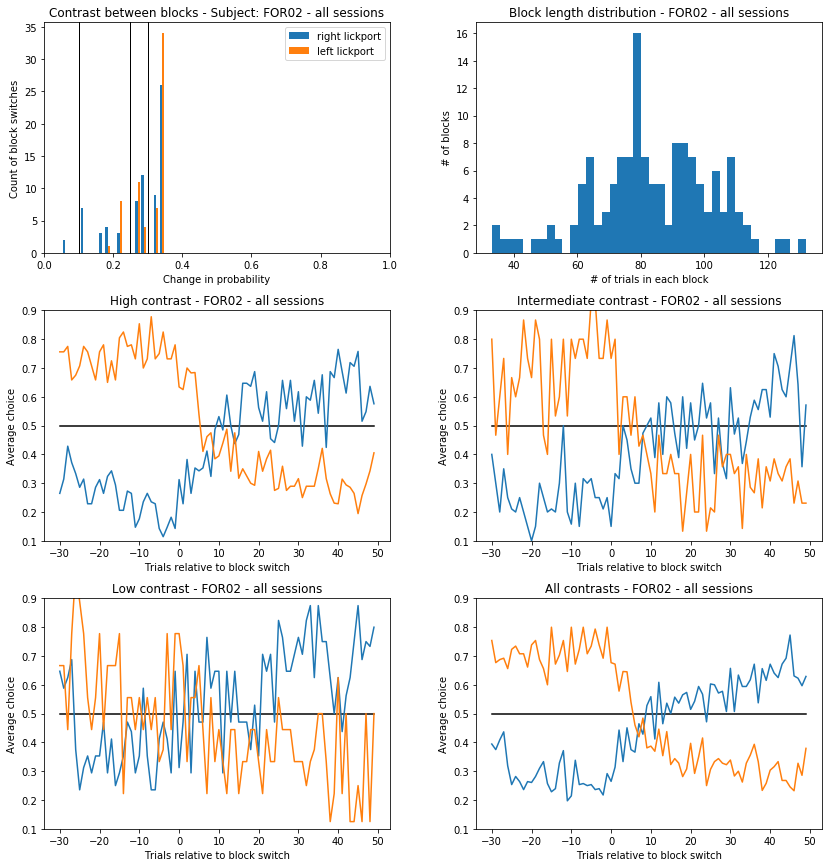

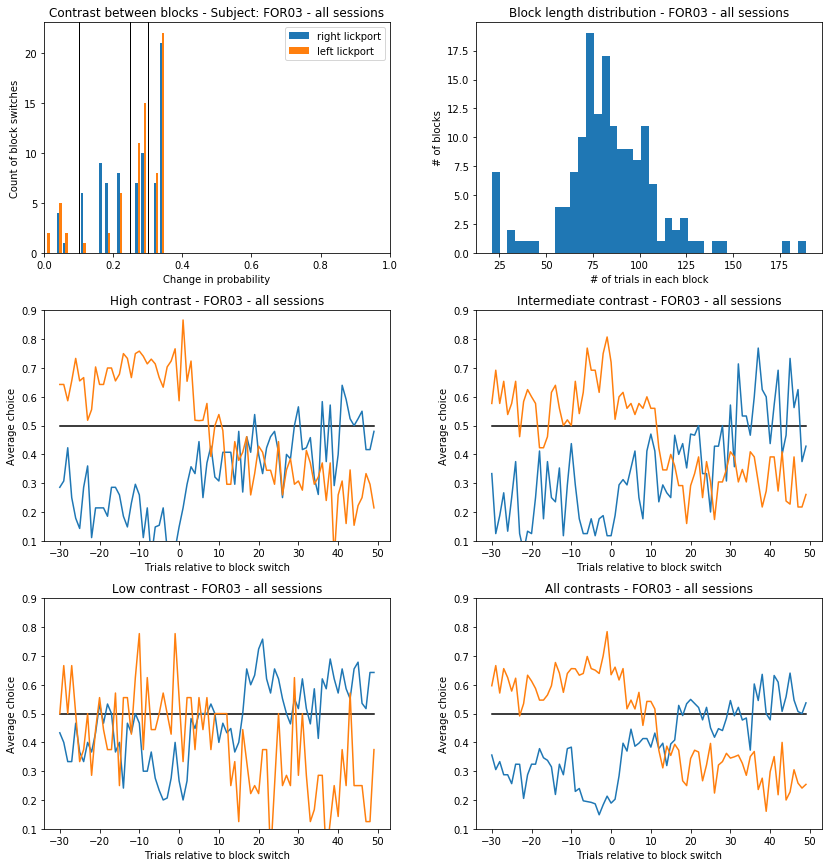

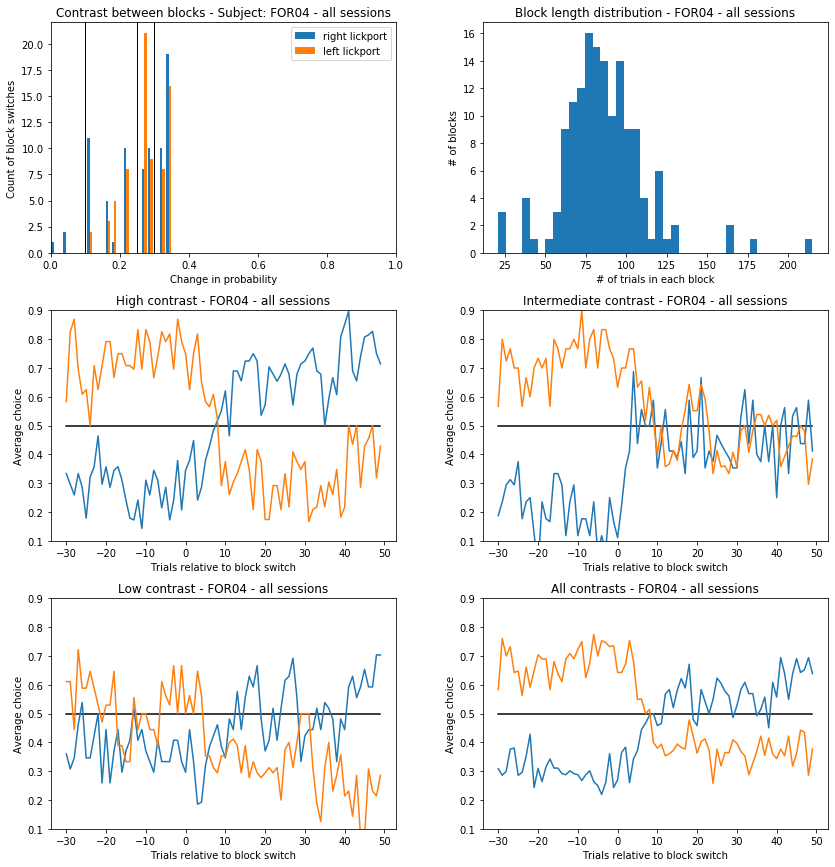

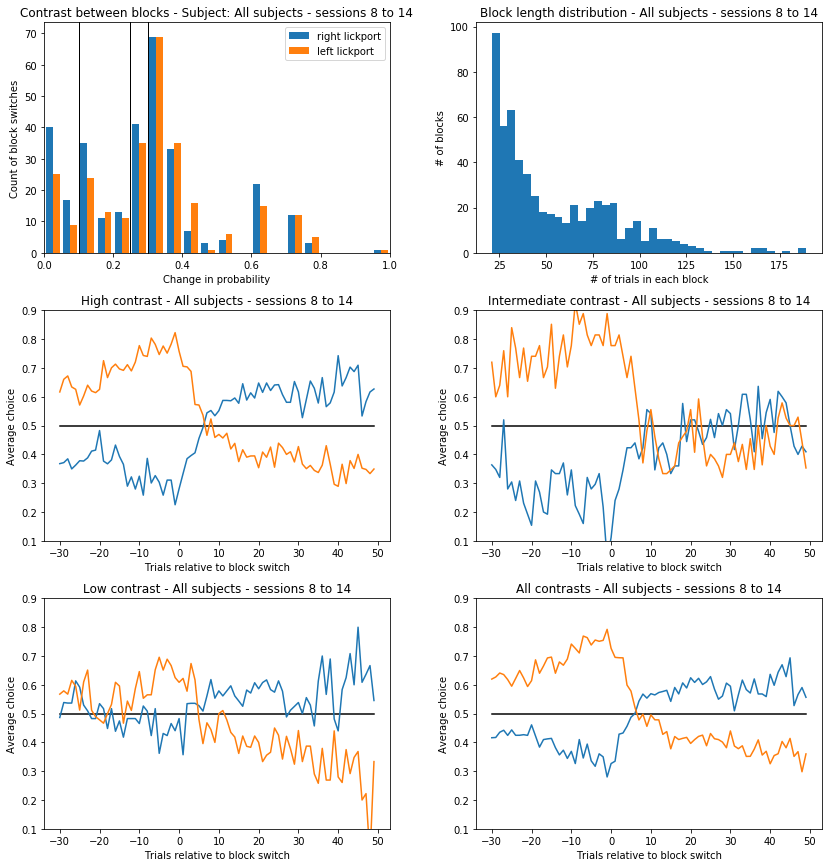

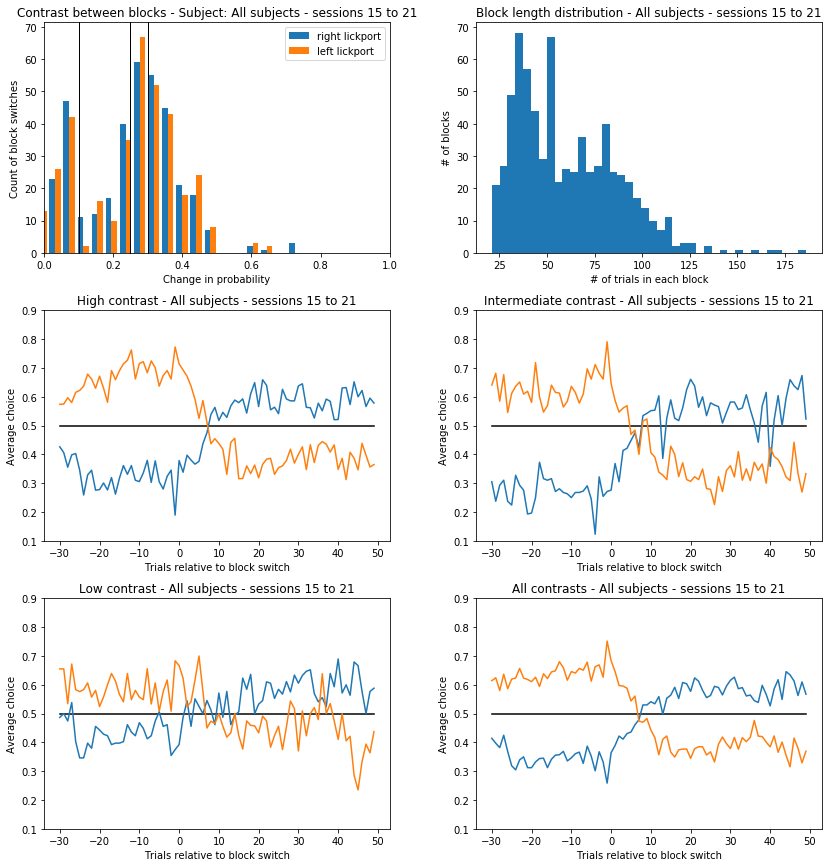

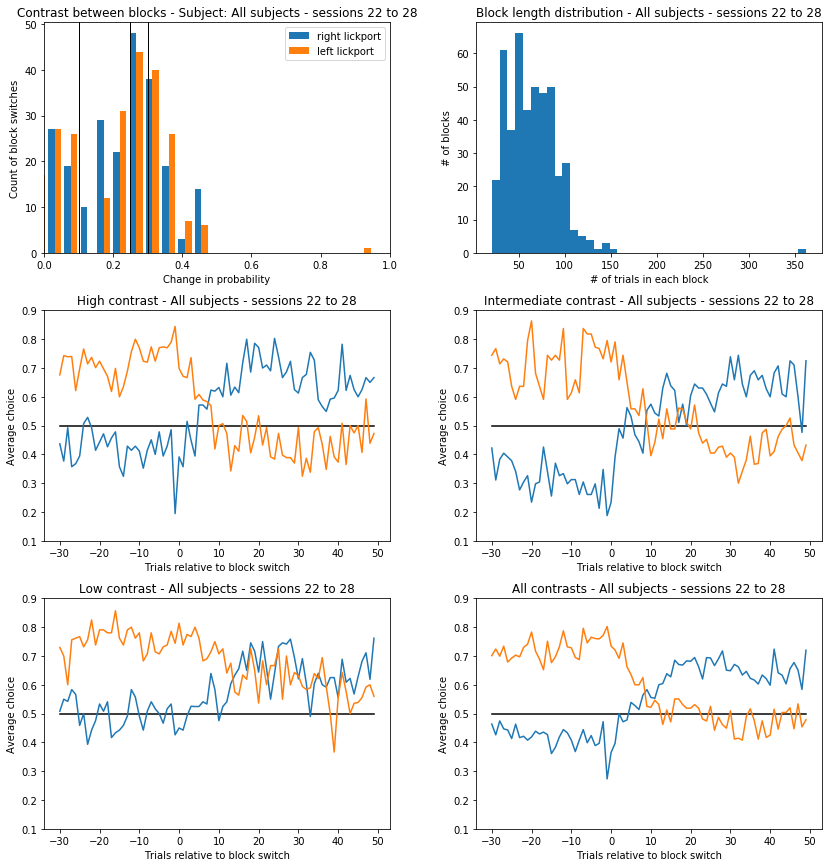

In [12]:
plot_block_switches()
plot_block_switches('FOR01')
plot_block_switches('FOR02')
plot_block_switches('FOR03')
plot_block_switches('FOR04')
plot_block_switches(sessions = [8, 14])
plot_block_switches(sessions = [15, 21])
plot_block_switches(sessions = [22, 28])

# Logistic regression session by session

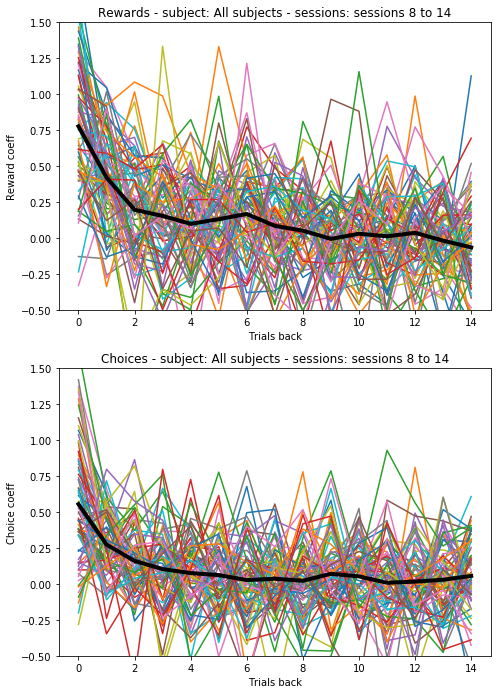

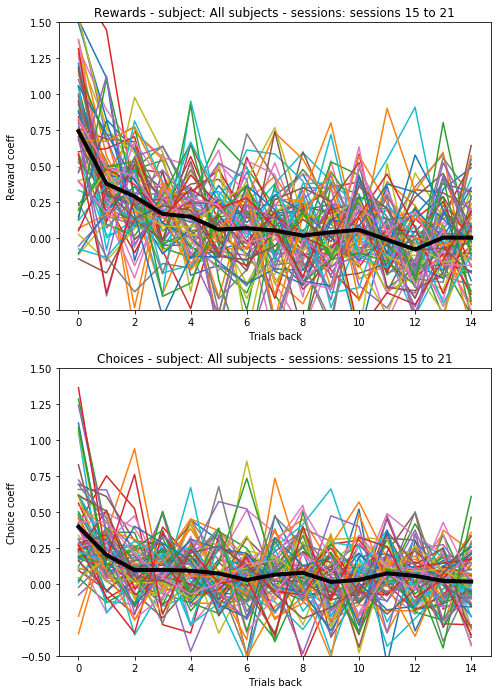

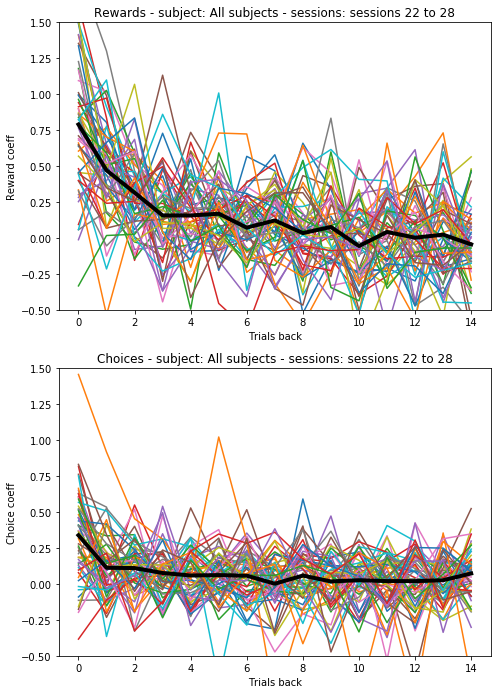

In [13]:
plotregressionaverage(sessions = [8,14])
plotregressionaverage(sessions = [15,21])
plotregressionaverage(sessions = [22,28])
